<a href="https://colab.research.google.com/github/Blaise-bf/thesis-files/blob/main/thesis_analysis_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation_models_pytorch --quiet
!pip install torchsummary --quiet
!pip install torchmetrics --quiet
!pip install -U albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchmetrics.segmentation import DiceScore



In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# images_dir = '/content/drive/MyDrive/thesis/thesis/images/train'
# cath_mask = '/content/drive/MyDrive/thesis/thesis/catheter/'
# atrial_mask = '/content/drive/MyDrive/thesis/thesis/atrial-mask/'

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np

def resize_to_square(
    img: np.ndarray,
    target_size: int,
    pad_color: int = 0,
    interpolation: int = cv2.INTER_CUBIC
) -> np.ndarray:
    """
    Resizes an image to a square while maintaining aspect ratio.
    Pads the remaining space with `pad_color` (default: 0/black).

    Args:
        img (np.ndarray): Input image (grayscale or color).
        target_size (int): Desired width & height of the square output.
        pad_color (int): Padding color (default 0 for black).

    Returns:
        np.ndarray: Square image of size (target_size, target_size).
    """
    h, w = img.shape[:2]

    # Scale the image to fit inside the target square
    scale = min(target_size / w, target_size / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation )

    # Calculate padding to center the image
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left

    # Apply padding
    square_img = cv2.copyMakeBorder(
        resized_img,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color
    )

    return square_img


def read_image_frompath(
    mask_paths: list[str],
    size: int | None = None,
    pad_color: int = 0,
    interpolation: int = cv2.INTER_CUBIC
) -> list[np.ndarray]:
    """
    Reads images from paths and optionally resizes them to squares.

    Args:
        mask_paths (list[str]): List of image file paths.
        size (int | None): If provided, resize images to (size x size).
        pad_color (int): Padding color (default 0 for black).

    Returns:
        list[np.ndarray]: List of images (resized if `size` is given).
    """
    images = []
    for path in mask_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read image at {path}")
            continue

        if size is not None:
            img = resize_to_square(img, size, pad_color, interpolation)
        images.append(img)

    return images


def load_base_unetmodel():
    model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b4",  # EfficientNet-b4 encoder
    encoder_weights="imagenet",      # Pretrained weights
    in_channels=1,                   # RGB channels
    classes=1                       # Single binary mask class
)
    return model


In [ ]:
service = 'colab'

### Setup
* Get paths of images from atrial mask, catheter mask and original image folder
* Ensure the corresponding labels are matched for each image


In [ ]:

# Read in meta data
met_df = pd.read_excel('/content/drive/MyDrive/msc_uhasselt/cath_ai_rev_anon.xlsx')
met_df.rename(columns={'arch (1-ok, 0-no)': 'arch',
                                 'tip (1-ok, 0-no)' : 'tip' }, inplace=True)


if service == 'kaggle':
# Paths to images
    train_ctheter_mask_dir = '/kaggle/input/thesis-files/train_catheter_masks/train_catheter_masks'
    test_ctheter_mask_dir = '/kaggle/input/thesis-files/test_catheter_masks'
    train_atrium_mask_dir = '/kaggle/input/thesis-files/train_atrium_masks/train_atrium_masks'
    test_atrium_mask_dir = '/kaggle/input/thesis-files/test_atrium_masks'
    original_images_dir = '/kaggle/input/thesis-files/train_images/train_images'
    original_test_images_dir = '/kaggle/input/thesis-files/test_images'
else:
    train_ctheter_mask_dir = '/content/drive/MyDrive/msc_uhasselt/train_catheter_masks'
    test_ctheter_mask_dir = '/content/drive/MyDrive/msc_uhasselt/test_catheter_masks'
    train_atrium_mask_dir = '/content/drive/MyDrive/msc_uhasselt/train_atrium_masks'
    test_atrium_mask_dir = '/content/drive/MyDrive/msc_uhasselt/test_atrium_masks'
    original_images_dir = '/content/drive/MyDrive/msc_uhasselt/train_images'
    original_test_images_dir = '/content/drive/MyDrive/msc_uhasselt/test_images'




def get_filenames(dir_path):
    filenames = [f for f in os.listdir(dir_path) if f.endswith('.tif')]
    return filenames

def get_ids(filenames):
    ids = {f.split('.')[0] for f in filenames}
    return ids

def get_full_paths(dir_path, filenames):
    full_paths = [os.path.join(dir_path, f"{img_id}.tif") for img_id in filenames]
    return full_paths


# Get filenames (not full paths yet)
catheter_labels = get_filenames(train_ctheter_mask_dir)
atrial_labels = get_filenames(train_atrium_mask_dir)
test_catheter_labels = get_filenames(test_ctheter_mask_dir)
test_atrial_labels = get_filenames(test_atrium_mask_dir)

# Extract IDs
# The files typically have this form 'IMG-0025-00001.tif'
# A set data structure is used to ensure set concepts like intersection or union can be used
ids_cath = {f.split('.')[0] for f in catheter_labels} # this should return ids like IMG-0025-00001
ids_atria = {f.split('.')[0] for f in atrial_labels}
test_cath_ids = {f.split('.')[0] for f in test_catheter_labels}
test_atria_ids = {f.split('.')[0] for f in test_atrial_labels}

# Find common IDs
common_ids = sorted(list(ids_cath.intersection(ids_atria)))  # sorted is optional, but keeps things in order
common_ids_test = sorted(list(test_cath_ids.intersection(test_atria_ids)))

# common_ids_test.remove('IMG-0273-00001') # This image returns blank predictions for both masks
common_ids_test = sorted(common_ids_test)

# Now build matched paths
valid_cathetr_paths = get_full_paths(train_ctheter_mask_dir, common_ids)
valid_atrial_paths = get_full_paths(train_atrium_mask_dir, common_ids)
valid_test_cathetr_paths = get_full_paths(test_ctheter_mask_dir, common_ids_test)
valid_test_atrial_paths = get_full_paths(test_atrium_mask_dir, common_ids_test)
valid_images_paths = get_full_paths(original_images_dir, common_ids)
valid_test_paths = get_full_paths(original_test_images_dir, common_ids_test)

print(f"Number of images: {len(valid_images_paths)}")
print(f"Number of catheter masks: {len(valid_cathetr_paths)}")
print(f"Number of atrial masks: {len(valid_atrial_paths)}")
print(f"Number of test images: {len(valid_test_paths)}")
print(f"Number of test catheter masks: {len(valid_test_cathetr_paths)}")
print(f"Number of test atrial masks: {len(valid_test_atrial_paths)}")


Number of images: 200
Number of catheter masks: 200
Number of atrial masks: 200
Number of test images: 46
Number of test catheter masks: 46
Number of test atrial masks: 46


In [ ]:
# det the dimentions of all images

def get_image_dimentions(paths, label = "Training"):
    heights = []
    widths  = []
    for path in paths:
        img = Image.open(path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
    max_width = max(widths)
    max_height = max(heights)
    min_width = min(widths)
    min_height = min(heights)
    print(f"{label} images dimentions:")
    print(f"Max width : {max_width}")
    print(f"Max height: {max_height}")
    print(f"Min width: {min_width}")
    print(f"Min height: {min_height}")

get_image_dimentions(valid_images_paths)
print('\n')
get_image_dimentions(valid_test_paths, label="Test")

Training images dimentions:
Max width : 3408
Max height: 3056
Min width: 2264
Min height: 2039


Test images dimentions:
Max width : 4248
Max height: 3480
Min width: 2278
Min height: 2364


In [ ]:
met_df.head()
id_tip = dict(zip(met_df['ap_id'], met_df['tip']))
train_tip_labels = [id_tip[id] for id in common_ids]
test_tip_labels = [id_tip[id] for id in common_ids_test]

print(f"Number of tip labels: {len(train_tip_labels)}")
print(f"Number of test tip labels: {len(test_tip_labels)}")
all_labels = train_tip_labels + test_tip_labels
print(f"Number of all labels: {len(all_labels)}")

Number of tip labels: 200
Number of test tip labels: 46
Number of all labels: 246


In [ ]:
# Unzip .7z files
# /content/drive/MyDrive/thesis/thesis/model/trained models.7z

# !sudo apt-get install p7zip-full
# !7z x /content/drive/MyDrive/thesis/thesis/model/"trained models.7z" -o/content/drive/MyDrive/thesis/thesis/model

In [ ]:
# unzip files atrial masks in /content/drive/MyDrive/thesis/thesis/ to /content/drive/MyDrive/thesis/thesis/atrial-mask
# !unzip /content/drive/MyDrive/msc_uhasselt/pretrained.zip -d /content/drive/MyDrive/msc_uhasselt/models
# !unzip /content/drive/MyDrive/thesis/thesis/heart_test.zip -d /content/drive/MyDrive/thesis/thesis/atrial-mask/test

In [ ]:


# Image transformations (You might want to adjust these based on your training setup)
transform_image = transforms.Compose([
    transforms.Resize((960, 960)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


def predict_catheter_segmentation(image_path, unet_model, device, size=960, transform=transform_image, clip=2):
    # Open the image using PIL and convert to grayscale
    image_pil = Image.open(image_path).convert("L")
    unet_model = unet_model.to(device)

    # Convert to NumPy array
    image_np = np.array(image_pil)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
    clahe_image_np = clahe.apply(image_np)

    # Resize image while maintaining aspect ratio
    resized_aspx = resize_to_square(img=clahe_image_np, target_size=size)

    # Convert back to PIL Image
    clahe_image_pil = Image.fromarray(resized_aspx)

    # Apply transform (e.g., ToTensor, normalization)
    if transform:
        image_tensor = transform(clahe_image_pil).unsqueeze(0).to(device) # unsqueeze adds a sample dimenstion (N, C, W, H)
    else:
        image_tensor = transforms.ToTensor()(clahe_image_pil).unsqueeze(0).to(device)

    # Predict mask using U-Net++
    unet_model.eval()
    with torch.inference_mode():
        output = unet_model(image_tensor)
        output = torch.sigmoid(output)
        mask = (output > 0.5).float()

    return mask.cpu().squeeze().numpy(), transforms.ToPILImage()(image_tensor.cpu().squeeze())



# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
unet_model = load_base_unetmodel()

if service == 'kaggle':
    unet_model.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/januarycatheter050225CLAHE60.pth'))  # Update with your model path
else:
    unet_model.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/januarycatheter050225CLAHE60.pth'))




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [ ]:
unet_model_atrial = load_base_unetmodel()
if service == 'kaggle':
    unet_model_atrial.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/januarycatheter050225przedsionekCLAHE61.pth'))  # Update with your model path
else:
    unet_model_atrial.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/januarycatheter050225przedsionekCLAHE61.pth'))


In [ ]:
# transform_image = transforms.Compose([
#     transforms.Resize((960, 960)),
#     transforms.ToTensor(),
# ])



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_catheter_segmentation_clahe(image_path, unet_model,
                                  device, transform=transform_image,
                                  size=960,
                                  apply_clahe1=False,
                                  apply_clahe2=False,
                                  apply_clahe3=False,
                                  apply_clahe4=False):
    image = Image.open(image_path).convert("L")

    if apply_clahe1:
        image_np = np.array(image)
        clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8, 8))
        image_np = clahe.apply(image_np)
        resized_aspx = resize_to_square(img=image_np, target_size=size)
        image = Image.fromarray(resized_aspx)
    elif apply_clahe2:
        image_np = np.array(image)
        clahe = cv2.createCLAHE(clipLimit=4.1, tileGridSize=(8, 8))
        image_np = clahe.apply(image_np)
        resized_aspx = resize_to_square(img=image_np, target_size=size)
        image = Image.fromarray(resized_aspx)
    elif apply_clahe3:
        image_np = np.array(image)
        clahe = cv2.createCLAHE(clipLimit=7.1, tileGridSize=(8, 8))
        image_np = clahe.apply(image_np)
        resized_aspx = resize_to_square(img=image_np, target_size=size)
        image = Image.fromarray(resized_aspx)
    elif apply_clahe4:
        image_np = np.array(image)
        clahe = cv2.createCLAHE(clipLimit=9.1, tileGridSize=(8, 8))
        image_np = clahe.apply(image_np)
        resized_aspx = resize_to_square(img=image_np, target_size=size)
        image = Image.fromarray(resized_aspx)

    if transform:
        image = transform(image).unsqueeze(0).to(device)

    # model = unet_model.to(device)
    unet_model.eval()
    with torch.no_grad():
        mask = unet_model(image)
        mask = torch.sigmoid(mask)
        mask = (mask > 0.5).float()
        original_image = transforms.ToPILImage()(image.cpu().squeeze())
    return mask.cpu().numpy(), original_image


unet_cath = load_base_unetmodel()

unet_cath1 = load_base_unetmodel()

unet_cath2 = load_base_unetmodel()

unet_cath3 = load_base_unetmodel()

# Load models
if service == 'kaggle':
    unet_cath.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentcatheter.pth'))
    unet_cath1.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentcatheter40clahe.pth'))
    unet_cath2.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentcatheter60clahe.pth'))
    unet_cath3.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentcatheter80clahe.pth'))
else:
    unet_cath.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentcatheter.pth'))
    unet_cath1.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentcatheter40clahe.pth'))
    unet_cath2.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentcatheter60clahe.pth'))
    unet_cath3.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentcatheter80clahe.pth'))


unet_cath.to(device)
unet_cath1.to(device)
unet_cath2.to(device)
unet_cath3.to(device)


cath_models = [unet_cath, unet_cath1, unet_cath2, unet_cath3]

weights = [0.1, 0.2, 0.2, 0.5]




unet_atrium = load_base_unetmodel()
unet_atrium1 = load_base_unetmodel()

unet_atrium2 = load_base_unetmodel()

unet_atrium3 = load_base_unetmodel()


if service == 'kaggle':
    unet_atrium.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset2.pth'))
    unet_atrium1.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augument.pth'))
    unet_atrium2.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentclahe40.pth'))
    unet_atrium3.load_state_dict(torch.load('/kaggle/input/thesis-files/pretrained/trained models/mayhasseltbigset20augumentclahe60.pth'))
else:
    unet_atrium.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset2.pth'))
    unet_atrium1.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augument.pth'))
    unet_atrium2.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentclahe40.pth'))
    unet_atrium3.load_state_dict(torch.load('/content/drive/MyDrive/msc_uhasselt/models/trained models/mayhasseltbigset20augumentclahe60.pth'))


unet_atrium.to(device)
unet_atrium1.to(device)
unet_atrium2.to(device)
unet_atrium3.to(device)



def get_weighted_masks(
    images_dir,
    models,
    device,
    clahe_parms,
    weights,
    transform=transform_image


                      ):
    all_predictions = []
    clahe_images = []
    for image_path in images_dir:
        predictions = []
        for i, model in enumerate(models):
            mask, clahe_image = predict_catheter_segmentation(image_path, model, device, transform, **clahe_parms[i])
            predictions.append(mask)
            if i == 0:
                clahe_images.append(clahe_image)
        combined_pred = (weights[0] * predictions[0] +
                weights[1] * predictions[1] +
                weights[2] * predictions[2] +
                weights[3] * predictions[3])
        combined_pred = (combined_pred > 0.5).astype()
        all_predictions.append(combined_pred)

    all_predictions = np.array(all_predictions)
    return all_predictions, np.array(clahe_images)



clahe_parms = [
    {'apply_clahe1': True, 'apply_clahe2': False, 'apply_clahe3': False, 'apply_clahe4': False},
    {'apply_clahe1': False, 'apply_clahe2': True, 'apply_clahe3': False, 'apply_clahe4': False},
    {'apply_clahe1': False, 'apply_clahe2': False, 'apply_clahe3': True, 'apply_clahe4': False},
    {'apply_clahe1': False, 'apply_clahe2': False, 'apply_clahe3': False, 'apply_clahe4': True}
]


unet_atrium_models = [unet_atrium, unet_atrium1, unet_atrium2, unet_atrium3]

clahe_settings = {'1': 0.1, '2': 4.1, '3': 7.1, '4': 9.1}



In [ ]:
def get_masks(test_image_paths, unet_model, device,clahe_parm, clahe=None, clip=None):
    all_predictions = []
    clahe_images = []

    for image_path in test_image_paths:
        mask, clahe_image = predict_catheter_segmentation_clahe(image_path, unet_model, device, **clahe_parm)
        all_predictions.append(mask)

        if clahe:
            clahe_images.append(clahe_image)


    all_predictions = np.array(all_predictions)
    return all_predictions, np.array(clahe_images) if clahe else None


def convert_np_tensor(np_array):
    return torch.from_numpy(np_array)

In [ ]:
# readin all masks and resize them to 960x960
train_catheter_masks = read_image_frompath(valid_cathetr_paths, size=960)
train_atrium_masks = read_image_frompath(valid_atrial_paths, size=960)
images = read_image_frompath(valid_images_paths, size=960)


In [ ]:
test_cathether_masks = read_image_frompath(valid_test_cathetr_paths, size=960)
test_atrium_masks = read_image_frompath(valid_test_atrial_paths, size=960)
test_images = read_image_frompath(valid_test_paths, size=960)

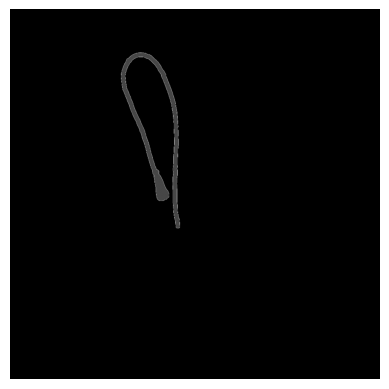

In [ ]:
plt.imshow(test_cathether_masks[5], cmap='gray')
plt.axis('off');

In [ ]:
train_catheter_masks = np.array(train_catheter_masks)
train_atrium_masks = np.array(train_atrium_masks)
images = np.array(images)

test_catheter_masks = np.array(test_cathether_masks)
test_atrium_masks = np.array(test_atrium_masks)
test_images = np.array(test_images)

print(train_catheter_masks.shape, train_atrium_masks.shape)

# convert to tensors
original_cath_tensor = torch.from_numpy(train_catheter_masks)
original_atrial_tensor = torch.from_numpy(train_atrium_masks)
original_images_tensor = torch.from_numpy(images)

test_cath_tensor = torch.from_numpy(test_catheter_masks)
test_atrial_tensor = torch.from_numpy(test_atrium_masks)
test_images_tensor = torch.from_numpy(test_images)


(200, 960, 960) (200, 960, 960)


In [ ]:
def get_binary_masks(masks):


    return (masks > 0).float()


ground_truth_atrium = get_binary_masks(test_atrial_tensor)
ground_truth_catheter = get_binary_masks(test_cath_tensor)

train_ground_truth_catheter = get_binary_masks(original_cath_tensor)
train_ground_truth_atrium   = get_binary_masks(original_atrial_tensor)

In [ ]:
def get_individual_masks(image_paths, unet_model, device, clahe=None, clip=2):
    all_predictions = []
    clahe_images = []

    for image_path in image_paths:
        mask, clahe_image = predict_catheter_segmentation(image_path, unet_model, device, clip=clip)
        all_predictions.append(mask)

        if clahe:
            clahe_images.append(clahe_image)

    return np.array(all_predictions), np.array(clahe_images) if clahe else None


In [ ]:

test_cath_masks, test_image_clahe = get_individual_masks(valid_test_paths, unet_cath, device, clip=clahe_settings['1'])
test_atrial_mask, _ = get_individual_masks(valid_test_paths, unet_atrium, device, clip=clahe_settings['1'])


train_cath_masks, train_image_clahe = get_individual_masks(valid_images_paths, unet_cath, device, clip=clahe_settings['1'])
train_atrial_mask, _ = get_individual_masks(valid_images_paths, unet_atrium, device, clip=clahe_settings['1'])

#
test_cath_masks_tensor = convert_np_tensor(test_cath_masks)
test_atrial_mask_tensor = convert_np_tensor(test_atrial_mask)
train_cath_masks_tensor = convert_np_tensor(train_cath_masks)
train_atrial_mask_tensor = convert_np_tensor(train_atrial_mask)

test_cath_masks1, test_image_clahe1 = get_individual_masks(valid_test_paths, unet_cath1, device, clip=clahe_settings['2'])
test_atrial_mask1, _ = get_individual_masks(valid_test_paths, unet_atrium1, device, clip=clahe_settings['2'])

train_cath_masks1, train_image_clahe1 = get_individual_masks(valid_images_paths, unet_cath1, device, clip=clahe_settings['2'])
train_atrial_mask1, _ = get_individual_masks(valid_images_paths, unet_atrium1, device, clip=clahe_settings['2'])

#
test_cath_masks_tensor1 = convert_np_tensor(test_cath_masks1)
test_atrial_mask_tensor1 = convert_np_tensor(test_atrial_mask1)
train_cath_masks_tensor1 = convert_np_tensor(train_cath_masks1)
train_atrial_mask_tensor1 = convert_np_tensor(train_atrial_mask1)

test_cath_masks2, _ = get_individual_masks(valid_test_paths, unet_cath2, device, clip=clahe_settings['3'])
test_atrial_mask2, _ = get_individual_masks(valid_test_paths, unet_atrium2, device, clip=clahe_settings['3'])

train_cath_masks2, train_image_clahe2 = get_individual_masks(valid_images_paths, unet_cath2, device, clip=clahe_settings['3'])
train_atrial_mask2, _ = get_individual_masks(valid_images_paths, unet_atrium2, device, clip=clahe_settings['3'])

#
test_cath_masks_tensor2 = convert_np_tensor(test_cath_masks2)
test_atrial_mask_tensor2 = convert_np_tensor(test_atrial_mask2)
train_cath_masks_tensor2 = convert_np_tensor(train_cath_masks2)
train_atrial_mask_tensor2 = convert_np_tensor(train_atrial_mask2)

test_cath_masks3, _ = get_individual_masks(valid_test_paths, unet_cath3, device, clip=clahe_settings['4'])
test_atrial_mask3, _ = get_individual_masks(valid_test_paths, unet_atrium3, device,clip=clahe_settings['4'])

train_cath_masks3, train_image_clahe3 = get_individual_masks(valid_images_paths, unet_cath3, device, clip=clahe_settings['4'])
train_atrial_mask3, _ = get_individual_masks(valid_images_paths, unet_atrium3, device, clip=clahe_settings['4'])

#
test_cath_masks_tensor3 = convert_np_tensor(test_cath_masks3)
test_atrial_mask_tensor3 = convert_np_tensor(test_atrial_mask3)
train_cath_masks_tensor3 = convert_np_tensor(train_cath_masks3)
train_atrial_mask_tensor3 = convert_np_tensor(train_atrial_mask3)



In [ ]:

test_cath_atrium_pairs = [(test_cath_masks_tensor, test_atrial_mask_tensor),
                     (test_cath_masks_tensor1, test_atrial_mask_tensor1),
                     (test_cath_masks_tensor2, test_atrial_mask_tensor2),
                     (test_cath_masks_tensor3, test_atrial_mask_tensor3)
                    ]
train_cath_atrium_pairs = [(train_cath_masks_tensor, train_atrial_mask_tensor),
                     (train_cath_masks_tensor1, train_atrial_mask_tensor1),
                     (train_cath_masks_tensor2, train_atrial_mask_tensor2),
                     (train_cath_masks_tensor3, train_atrial_mask_tensor3)
                    ]

In [ ]:
test_cath_masks_tensor.unsqueeze(1).shape

torch.Size([45, 1, 960, 960])

In [ ]:
def combine_channels(chanel1, chanel2):

    return torch.stack([chanel1, chanel2], dim = 1)

def combine_tensor_batch(batch1, batch2):
    return torch.cat([batch1, batch2], dim=0)

In [ ]:
from torchmetrics.functional.segmentation import dice_score

def calculate_dice_score(y_true, y_pred):
    score = dice_score(y_true, y_pred, num_classes=2,  average='micro')
    # get average score
    return score.cpu().numpy().mean()

calculate_dice_score(ground_truth_atrium, test_atrial_mask_tensor.squeeze())


# for
dice_pairs = []

for cath, atria in test_cath_atrium_pairs:
    atria_dice = calculate_dice_score(ground_truth_atrium, atria.squeeze())
    cath_dice  = calculate_dice_score(ground_truth_catheter, cath.squeeze())
    dice_pairs.append((cath_dice, atria_dice))

for i, dice in enumerate(dice_pairs):
    print('===================================================')
    print(f'Clahe strategy--{i}, atrial-segmentation dice: {dice[1]:.3f}; CVC segmentation-dice: {dice[0]:.3f}')

Clahe strategy--0, atrial-segmentation dice: 0.447; CVC segmentation-dice: 0.813
Clahe strategy--1, atrial-segmentation dice: 0.726; CVC segmentation-dice: 0.815
Clahe strategy--2, atrial-segmentation dice: 0.742; CVC segmentation-dice: 0.814
Clahe strategy--3, atrial-segmentation dice: 0.733; CVC segmentation-dice: 0.821


In [ ]:
conbined_tensors_clahe = {

    'clahe1': combine_tensor_batch(
        combine_channels(test_cath_atrium_pairs[0][0], test_cath_atrium_pairs[0][1]),
        combine_channels(train_cath_atrium_pairs[0][0], train_cath_atrium_pairs[0][1])
    )
    # 'clahe2': combine_tensor_batch(
    #     combine_channels(test_cath_atrium_pairs[1][0], test_cath_atrium_pairs[1][1]),
    #     combine_channels(train_cath_atrium_pairs[1][0], train_cath_atrium_pairs[1][1])
    # )
    # 'clahe3': combine_tensor_batch(
    #     combine_channels(test_cath_atrium_pairs[2][0], test_cath_atrium_pairs[2][1]),
    #     combine_channels(train_cath_atrium_pairs[2][0], train_cath_atrium_pairs[2][1])
    # ),
    # 'clahe4': combine_tensor_batch(
    #     combine_channels(test_cath_atrium_pairs[3][0], test_cath_atrium_pairs[3][1]),
    #     combine_channels(train_cath_atrium_pairs[3[0], train_cath_atrium_pairs[3][1])
    # )

}

In [ ]:
_, train_clahes = get_individual_masks(valid_images_paths, unet_cath, device, clahe=True)

_, test_clahes = get_individual_masks(valid_test_paths, unet_atrium, device, clahe=True)

In [ ]:
# train_predictions_atrium, _ = get_individual_masks(valid_images_paths, unet_model_atrial, device)
# test_predictions_atrium, _ = get_individual_masks(valid_test_paths, unet_model_atrial, device)

In [ ]:

# mask_atrium = np.concatenate((train_predictions_atrium, test_predictions_atrium), axis=0)
# mask_catheter = np.concatenate((train_predictions_catheter, test_predictions_catheter), axis=0)
# clahe_images = np.concatenate((train_clahes, test_clahes), axis=0)

In [ ]:
# atrium_tensor = torch.from_numpy(mask_atrium)
# catheter_tensor = torch.from_numpy(mask_catheter)
# clahe_tensor = torch.from_numpy(clahe_images)

# atrium_catheter_tensor = torch.stack((atrium_tensor, catheter_tensor), dim=1)
# atrium_catheter_tensor.shape

In [ ]:
# initial_model_preds = (torch.from_numpy(test_predictions_catheter), torch.from_numpy(test_predictions_atrium))

# atria_dice = calculate_dice_score(ground_truth_atrium, initial_model_preds[1].squeeze())
# cath_dice  = calculate_dice_score(ground_truth_catheter, initial_model_preds[0].squeeze())

# print('===================================================')
# print(f'Clahe strategy--initial-model, atrial-segmentation dice: {atria_dice:.3f}; CVC segmentation-dice: {cath_dice:.3f}')

In [ ]:
train_clahes.shape

(200, 960, 960)

In [ ]:
(valid_test_paths[0].split('/')[-1]).replace('.tif', '' )

'IMG-0001-00001'

In [ ]:
def get_id_from_path(path: str) -> str:
    return path.split('/')[-1].replace('.tif', '')

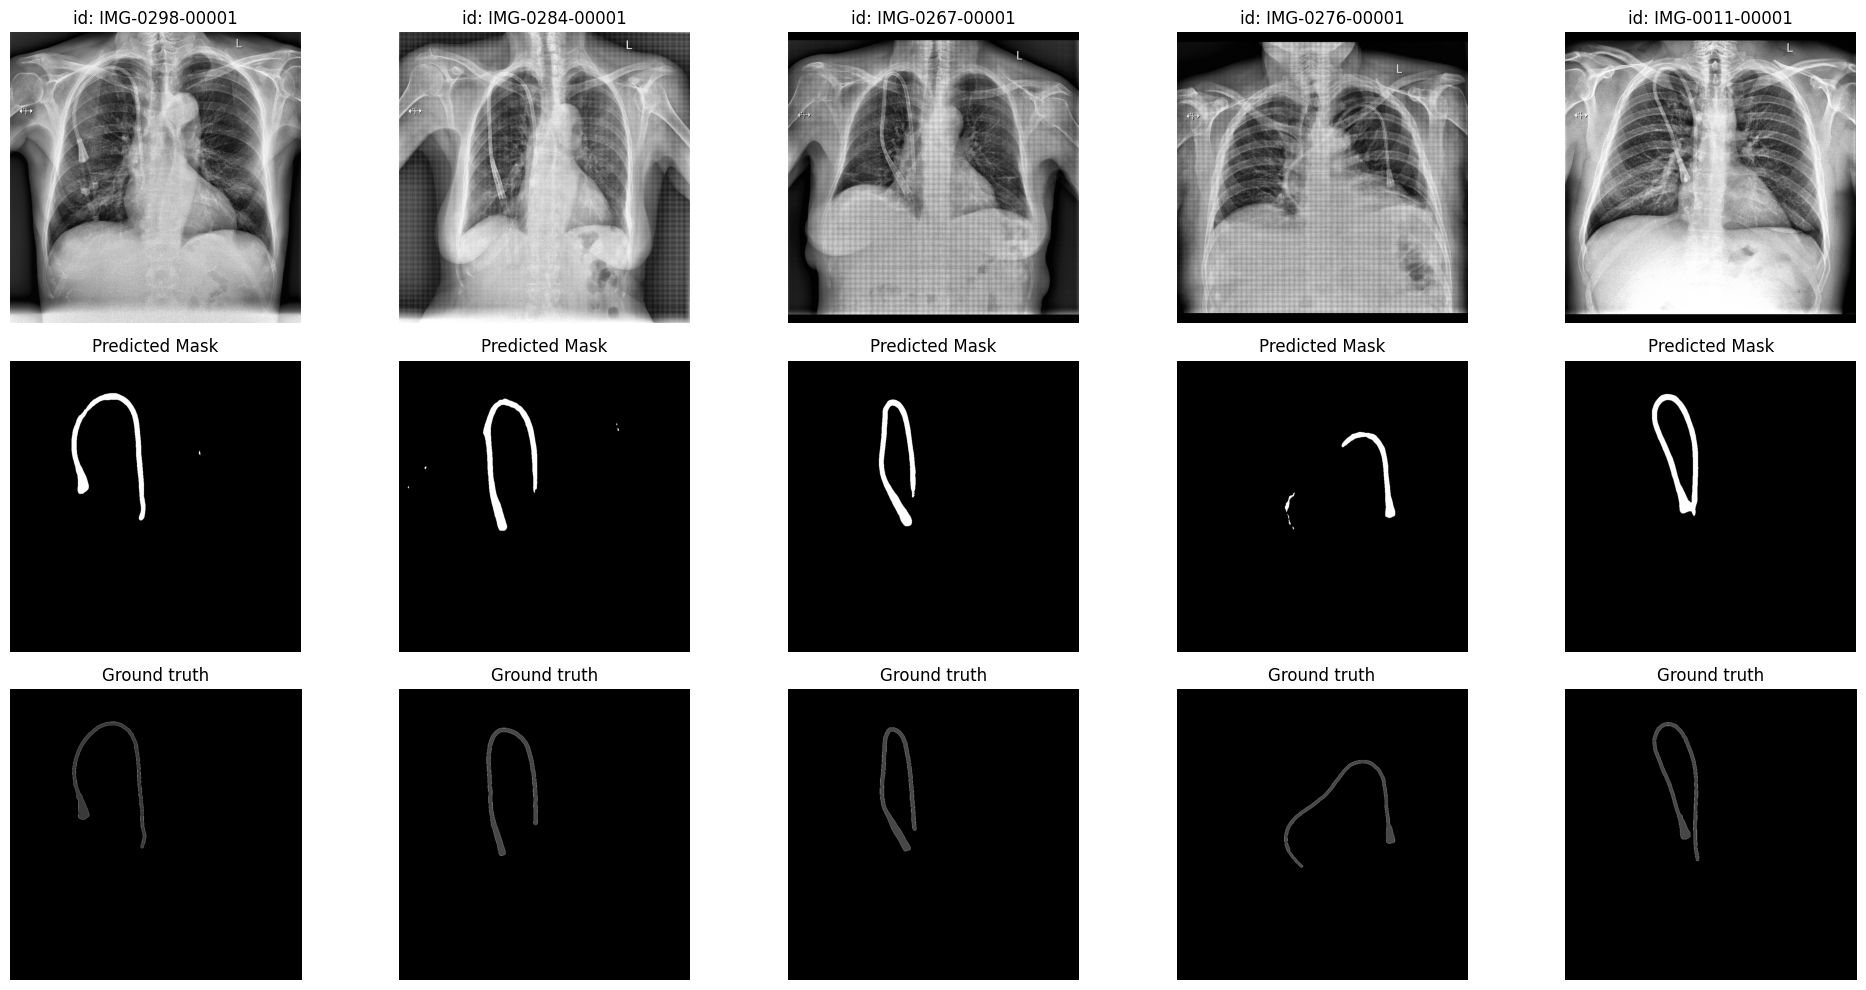

In [ ]:

# Randomly select 5 images from the test directory
import random
random_indices = random.sample(range(len(valid_test_paths)), 5)

random_images = [valid_test_paths[i] for i in random_indices]
random_masks = [valid_test_cathetr_paths[i] for i in random_indices]


# Create a plot with first row of actual images, second of predicted mask, last row of actual masks
fig, axes = plt.subplots(3, len(random_images), figsize=(20, 10))

for i, img_path in enumerate(random_images):
    actual_mask = cv2.imread(random_masks[i], cv2.IMREAD_GRAYSCALE)
    predicted_mask, clahe_image = predict_catheter_segmentation(img_path, unet_cath1, device, clip=2)
    axes[0, i].imshow(clahe_image, cmap='gray')
    axes[0, i].set_title(f"id: {get_id_from_path(random_images[i])}")
    axes[0, i].axis('off')
    axes[1, i].imshow(predicted_mask, cmap='gray')
    axes[1, i].set_title(f"Predicted Mask")
    axes[1, i].axis('off')
    axes[2, i].imshow(resize_to_square(img=actual_mask, target_size=960), cmap='gray')
    axes[2, i].set_title(f"Ground truth")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

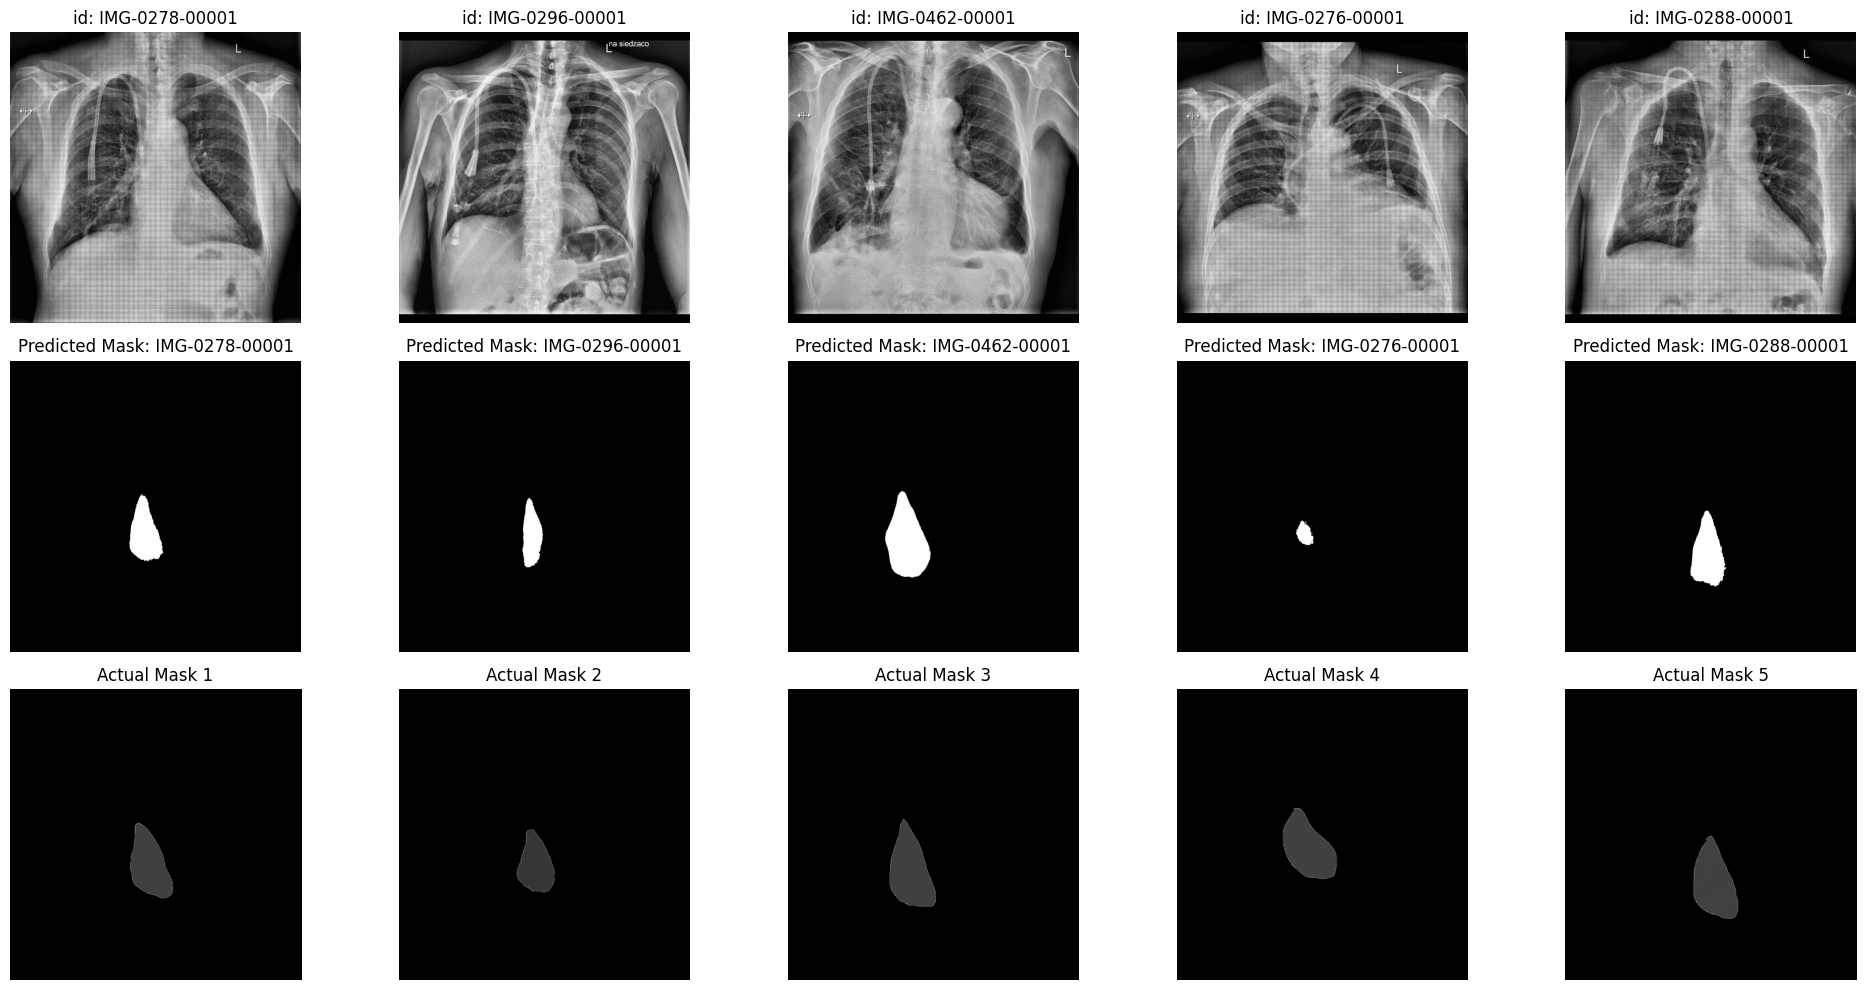

In [ ]:

# Randomly select 5 images from the test directory
# import random
import random
random_indices = random.sample(range(len(valid_test_paths)), 5)

random_images = [valid_test_paths[i] for i in random_indices]
random_masks = [valid_test_atrial_paths[i] for i in random_indices]


# Create a plot with first row of actual images, second of predicted mask, last row of actual masks
fig, axes = plt.subplots(3, len(random_images), figsize=(20, 10))

for i, img_path in enumerate(random_images):
    actual_mask = cv2.imread(random_masks[i], cv2.IMREAD_GRAYSCALE)
    predicted_mask, clahe_image = predict_catheter_segmentation(img_path, unet_atrium, device, clip = 2)
    axes[0, i].imshow(clahe_image, cmap='gray')
    axes[0, i].set_title(f"id: {get_id_from_path(random_images[i])}")
    axes[0, i].axis('off')
    axes[1, i].imshow(predicted_mask, cmap='gray')
    axes[1, i].set_title(f"Predicted Mask: {get_id_from_path(random_masks[i])}")
    axes[1, i].axis('off')
    axes[2, i].imshow(resize_to_square(img=actual_mask, target_size=960), cmap='gray')
    axes[2, i].set_title(f"Actual Mask {i+1}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
x
np.nonzero(x)

(array([0, 1, 2, 2]), array([0, 1, 0, 1]))

In [ ]:
from skimage.morphology import skeletonize, medial_axis
from scipy.ndimage import distance_transform_edt
import numpy as np
from scipy.signal import convolve2d

def vertical_distance_features(atrium_mask, catheter_mask):
    try:
        # Convert PyTorch tensors to numpy if needed
        if hasattr(atrium_mask, 'cpu'):
            atrium_mask = atrium_mask.cpu().numpy()
        if hasattr(catheter_mask, 'cpu'):
            catheter_mask = catheter_mask.cpu().numpy()

        # 1) Find atrial boundaries
        atrium_rows = np.nonzero(atrium_mask)[0]
        if len(atrium_rows) == 0:
            raise ValueError("Empty atrium mask")
        atrium_top, atrium_bottom = atrium_rows.min(), atrium_rows.max()

        # 2) Process catheter mask
        cath_mask = catheter_mask.astype(bool)
        if not np.any(cath_mask):
            raise ValueError("Empty catheter mask")

        # 3) Find catheter skeleton and endpoints
        skeleton = skeletonize(cath_mask)

        # Alternative endpoint detection without thin()
        # Endpoints are points with exactly one neighbor in skeleton
        kernel = np.array([[1,1,1],
                           [1,0,1],
                           [1,1,1]])
        conv = convolve2d(skeleton.astype(int), kernel, mode='same')
        endpoints = np.argwhere((skeleton > 0) & (conv == 1))

        # 4) Calculate thickness map using distance transform
        dt_cat = distance_transform_edt(cath_mask)
        thickness_map = dt_cat * 2  # Convert radius to diameter

        # 5) Identify potential tip candidates (endpoints + thinnest points)
        if len(endpoints) == 0:  # Fallback for looped catheters
            endpoints = np.argwhere(skeleton)

        # Find thinnest endpoint
        min_thickness = np.inf
        tip_row = None
        for y, x in endpoints:
            thickness = thickness_map[y, x]
            if thickness < min_thickness:
                min_thickness = thickness
                tip_row = y

        # 6) Fallback if no endpoints found
        if tip_row is None:
            cath_rows = np.nonzero(cath_mask)[0]
            cath_top, cath_bottom = cath_rows.min(), cath_rows.max()
            tip_row = cath_top if (thickness_map[cath_top].mean() <
                                 thickness_map[cath_bottom].mean()) else cath_bottom

        # 7) Calculate distances relative to tip
        dist_to_top = tip_row - atrium_top
        dist_to_bottom = atrium_bottom - tip_row

        return {
            "atrium_top": int(atrium_top),
            "atrium_bottom": int(atrium_bottom),
            "tip_row": int(tip_row),
            "dist_to_atria_top": int(dist_to_top),
            "dist_to_atria_bottom": int(dist_to_bottom),
            "min_thickness": float(min_thickness)
        }

    except ValueError as e:
        return {
            "atrium_top": np.nan,
            "atrium_bottom": np.nan,
            "tip_row": np.nan,
            "dist_to_atria_top": np.nan,
            "dist_to_atria_bottom": np.nan,
            "min_thickness": np.nan
        }

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize



def hu_features(mask):
    m = cv2.moments(mask.astype(np.uint8))
    hu = cv2.HuMoments(m).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-30)
    return hu_log

def extract_features(atrium_mask, catheter_mask, index=None):
    atrium_mask = atrium_mask.cpu().numpy()
    catheter_mask = catheter_mask.cpu().numpy()
    # image = image.cpu().numpy() if image is not None else None

    feats = {}

    try:
        A = regionprops(atrium_mask.astype(int))[0]
        C = regionprops(catheter_mask.astype(int))[0]
        minr, minc, maxr, maxc = A.bbox
        H = maxr - minr

        r_cent, c_cent = C.centroid
        feats["loc_norm"] = (r_cent - minr) / H

        third = H // 3
        upper_mask = np.zeros_like(atrium_mask)
        upper_mask[minr:minr + 2 * third, minc:maxc] = 1
        feats["frac_upper"] = (
            np.logical_and(catheter_mask, upper_mask).sum() / catheter_mask.sum()
        )

        dt = distance_transform_edt(atrium_mask)
        catheter_mask_bool = catheter_mask.astype(bool)
        dvals = dt[catheter_mask_bool]
        feats.update({
            "d_mean": dvals.mean(),
            "d_std": dvals.std(),
            "d_min": dvals.min(),
            "d_max": dvals.max(),
        })

        feats.update({
            "length": C.major_axis_length,
            "orientation": C.orientation,
            "eccentricity": C.eccentricity
        })

        skel = skeletonize(catheter_mask)
        ys, xs = np.nonzero(skel)
        vecs = np.diff(np.vstack([ys, xs]).T, axis=0)
        if vecs.shape[0] > 1:
            angles = np.arctan2(vecs[:, 0], vecs[:, 1])
            feats["curvature"] = np.std(np.diff(angles))
        else:
            feats["curvature"] = np.nan

        hu_log_catheter = hu_features(catheter_mask)
        hu_log_atrium = hu_features(atrium_mask)
        feats.update({f"hu_catheter_{i}": v for i, v in enumerate(hu_log_catheter)})
        feats.update({f"hu_atrium_{i}": v for i, v in enumerate(hu_log_atrium)})

        intersection = np.logical_and(catheter_mask, atrium_mask).sum()
        union = np.logical_or(catheter_mask, atrium_mask).sum()
        feats.update({
            "frac_catheter_in_atrium": intersection / catheter_mask.sum(),
            "frac_atrium_covered": intersection / atrium_mask.sum(),
            "iou": intersection / union,
        })

        feats.update(vertical_distance_features(atrium_mask, catheter_mask))



        return feats

    except IndexError as e:
        print(f"IndexError at index {index}: {e}")
    except Exception as e:
        print(f"Unexpected error at index {index}: {e}")

    # Fallback: return NaNs for all features
    fallback_feats = {k: np.nan for k in feats.keys()}
    fallback_feats.update({f"hu_catheter_{i}": np.nan for i in range(7)})
    fallback_feats.update({f"hu_atrium_{i}": np.nan for i in range(7)})
    fallback_feats.update({
        "loc_norm": np.nan,
        "frac_upper": np.nan,
        "d_mean": np.nan,
        "d_std": np.nan,
        "d_min": np.nan,
        "d_max": np.nan,
        "length": np.nan,
        "orientation": np.nan,
        "eccentricity": np.nan,
        "curvature": np.nan,
        "frac_catheter_in_atrium": np.nan,
        "frac_atrium_covered": np.nan,
        "iou": np.nan,
        "atrium_top": np.nan,
        "atrium_bottom": np.nan,
        "tip_row": np.nan,
        "dist_to_atria_top": np.nan,
        "dist_to_atria_bottom": np.nan,
        "min_thickness": np.nan
    })
    return fallback_feats


In [ ]:
atrium_tensor = combine_tensor_batch(train_atrial_mask_tensor, test_atrial_mask_tensor)

catheter_tensor = combine_tensor_batch(train_cath_masks_tensor, test_cath_masks_tensor)

clahe_tensor =  combine_tensor_batch(torch.from_numpy(train_clahes), torch.from_numpy(test_clahes))

In [ ]:
vertical_distance_features(atrium_tensor[0], catheter_tensor[0])

{'atrium_top': 415,
 'atrium_bottom': 657,
 'tip_row': 727,
 'dist_to_atria_top': 312,
 'dist_to_atria_bottom': -70,
 'min_thickness': 2.0}

In [ ]:
all_features = []
error_indices = []

for i in range(atrium_tensor.shape[0]):
    features = extract_features(atrium_tensor[i], catheter_tensor[i], index=i)
    if features is not None:
        all_features.append(features)
    else:
        error_indices.append(i)

if all_features:
    features_df = pd.DataFrame(all_features)
else:
    print("No features extracted successfully. DataFrame could not be created.")

for index in error_indices:
    plt.imshow(catheter_tensor[index].cpu().numpy(), cmap='gray')
    plt.title(f"Image with IndexError (index={index})")
    plt.show()


In [ ]:
for index in error_indices:
    plt.imshow(catheter_tensor[index].cpu().numpy(), cmap='gray')
    plt.title(f"Image with IndexError (index={index})")
    plt.show()

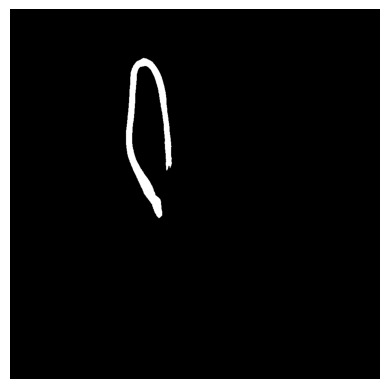

In [ ]:
plt.imshow(catheter_tensor[212].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:


print(original_cath_tensor.shape)

all_features = []
error_indices = []

for i in range(train_ground_truth_catheter.shape[0]):
    features = extract_features(train_ground_truth_atrium[i], train_ground_truth_catheter[i], index=i)
    if features is not None:
        all_features.append(features)
    else:
        error_indices.append(i)  # Store the index where the error occurred


# Create DataFrame (only if all_features is not empty)
if all_features:
    features_original_train_df = pd.DataFrame(all_features)
else:
    print("No features extracted successfully. DataFrame could not be created.")

# Visualize images with errors (if any)
for index in error_indices:
    problematic_image = catheter_tensor[index]
    plt.imshow(problematic_image, cmap='gray')
    plt.title(f"Image with IndexError (index={index})")
    plt.show()

all_features_test = []
error_indices_test = []

for i in range(ground_truth_catheter.shape[0]):
    features = extract_features(ground_truth_atrium[i], ground_truth_catheter[i], index=i)
    if features is not None:
        all_features_test.append(features)
    else:
        error_indices_test.append(i)
if all_features_test:
    features_original_test_df = pd.DataFrame(all_features_test)
else:
    print("No features extracted successfully. DataFrame could not be created.")


torch.Size([200, 960, 960])


In [ ]:
len(all_labels)

245

In [ ]:
features_df['tip'] = all_labels
features_df.head()

loc_norm  frac_upper     d_mean      d_std  d_min      d_max      length  \
0 -0.573124    0.000000   0.000000   0.000000    0.0   0.000000  524.829078   
1 -0.617153    0.097237   1.956555   6.802480    0.0  40.804412  466.488445   
2 -0.254280    0.330912  11.165692  16.740347    0.0  65.764732  605.810533   
3  0.564599    0.648835   4.242201   8.365366    0.0  39.217343  521.327721   
4  0.192536    0.137380   6.915393  15.954495    0.0  68.541958  471.499271   

   orientation  eccentricity  curvature  ...  frac_catheter_in_atrium  \
0    -0.011278      0.775525   2.799225  ...                 0.000000   
1     0.159830      0.913102   2.848327  ...                 0.095612   
2     0.238315      0.987932   2.853341  ...                 0.377299   
3     0.015060      0.971648   2.791499  ...                 0.263320   
4     0.113075      0.913585   2.966847  ...                 0.211627   

   frac_atrium_covered       iou  atrium_top  atrium_bottom  tip_row  \
0             0.000000  0.000000         415            657      727   
1             0.075323  0.043985         482            725      561   
2             0.323353  0.210837         498            727      648   
3             0.186424  0.122523          42            617      604   
4             0.163546  0.101628         338            531      515   

   dist_to_atria_top  dist_to_atria_bottom  min_thickness  tip  
0                312                   -70       2.000000    0  
1                 79                   164      13.416408    0  
2                150                    79      12.649111    1  
3                562                    13       8.000000    0  
4                177                    16      10.000000    0  

[5 rows x 34 columns]

In [ ]:
features_original_train_df['ap_id'] = [path.split('/')[-1].split('.')[0] for path in valid_images_paths]
features_original_test_df['ap_id'] = [path.split('/')[-1].split('.')[0] for path in valid_test_paths]

features_original_df = pd.concat([features_original_train_df, features_original_test_df], axis=0)

features_original_df.head()

loc_norm  frac_upper    d_mean      d_std  d_min      d_max      length  \
0 -0.537360    0.000000  0.000000   0.000000    0.0   0.000000  502.964623   
1 -0.734884    0.078675  1.723272   6.767466    0.0  42.190046  455.155943   
2 -0.394376    0.306931  9.931264  15.874283    0.0  64.884513  608.767960   
3 -0.197740    0.195364  5.084828   9.833485    0.0  39.812058  566.502397   
4  0.190952    0.119659  5.829131  14.543743    0.0  68.593003  474.708287   

   orientation  eccentricity  curvature  ...  frac_catheter_in_atrium  \
0    -0.213288      0.854994   2.822437  ...                 0.000000   
1     0.154725      0.905940   2.849335  ...                 0.075565   
2     0.238819      0.988148   2.920308  ...                 0.345120   
3     0.064762      0.974519   2.770936  ...                 0.280885   
4     0.144281      0.914675   2.971747  ...                 0.191807   

   frac_atrium_covered       iou  atrium_top  atrium_bottom  tip_row  \
0             0.000000  0.000000         404            645      397   
1             0.052475  0.031959         496            716      561   
2             0.261496  0.174774         517            727      672   
3             0.197616  0.131225         425            622      474   
4             0.138084  0.087294         351            520      525   

   dist_to_atria_top  dist_to_atria_bottom  min_thickness           ap_id  
0                 -7                   248       8.944272  IMG-0023-00001  
1                 65                   155      12.649111  IMG-0025-00001  
2                155                    55      10.000000  IMG-0027-00001  
3                 49                   148      12.000000  IMG-0029-00001  
4                174                    -5      11.661904  IMG-0031-00001  

[5 rows x 34 columns]

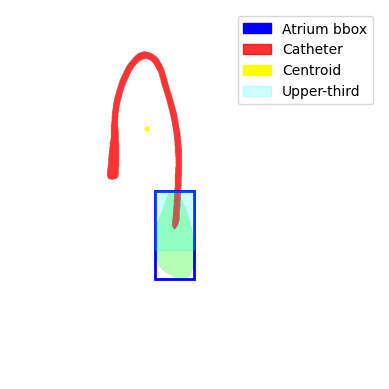

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from skimage.measure import regionprops




def viz_spatial_features(atrium_mask, catheter_mask, features):
    """
    Visualizes spatial features extracted from atrium and catheter masks.

    Args:
        atrium_mask: Atrium segmentation mask (NumPy array).
        catheter_mask: Catheter segmentation mask (NumPy array).
        features: Dictionary containing extracted features.
    """

    # Assuming atrium_mask and catheter_mask are NumPy arrays
    # Get region properties for the atrium to calculate minr, minc, maxr, maxc
    atrium_props = regionprops(atrium_mask.astype(int))[0]
    minr, minc, maxr, maxc = atrium_props.bbox
    H = maxr - minr
    width = maxc - minc  # Calculate width for bounding box

    # Get region properties for the catheter to calculate centroid
    catheter_props = regionprops(catheter_mask.astype(int))[0]
    r_cent, c_cent = catheter_props.centroid

    # Calculate third for upper-third region
    third = H // 3

    fig, ax = plt.subplots()

    # Show atrium mask as background with transparency
    atrium_mask_rgba = np.zeros((*atrium_mask.shape, 4), dtype=np.float32)
    atrium_mask_rgba[atrium_mask > 0, 3] = 0.3  # Set alpha to 0.3 where mask is True
    atrium_mask_rgba[atrium_mask > 0, 1] = 1  # Set green channel to 1
    ax.imshow(atrium_mask_rgba)

    # Show catheter mask on top with transparency
    catheter_mask_rgba = np.zeros((*catheter_mask.shape, 4), dtype=np.float32)
    catheter_mask_rgba[catheter_mask > 0, 3] = 0.8  # Set alpha to 0.8 where mask is True
    catheter_mask_rgba[catheter_mask > 0, 0] = 1  # Set red channel to 1
    ax.imshow(catheter_mask_rgba)

    # Bounding box (blue)
    bbox_patch = Rectangle((minc, minr), width, H, fill=False, linewidth=2, edgecolor='blue')
    ax.add_patch(bbox_patch)

    # Centroid (yellow)
    centroid_patch = Circle((c_cent, r_cent), radius=5, fill=True, color='yellow')
    ax.add_patch(centroid_patch)

    # Upper-third region (cyan)
    upper_third_patch = Rectangle((minc, minr), width, 2 * third, fill=True, alpha=0.2, color='cyan')
    ax.add_patch(upper_third_patch)

    # Create legend elements
    legend_elements = [
        Patch(facecolor='blue', edgecolor='blue', label='Atrium bbox'),
        Patch(facecolor='red', edgecolor='red', label='Catheter', alpha=0.8),  # Adjust alpha for legend
        Patch(facecolor='yellow', edgecolor='yellow', label='Centroid'),
        Patch(facecolor='cyan', edgecolor='cyan', label='Upper-third', alpha=0.2),  # Adjust alpha for legend
    ]

    # Add legend
    ax.legend(handles=legend_elements, loc='upper right')

    plt.axis("off")
    plt.show()


# Convert the tensors to NumPy arrays
atrium_mask_np = atrium_tensor[10].cpu().numpy()
catheter_mask_np = catheter_tensor[10].cpu().numpy()

# Call viz_spatial_features
viz_spatial_features(atrium_mask_np, catheter_mask_np, features_df.iloc[10])

# use original mask and catheter masks to visualize these


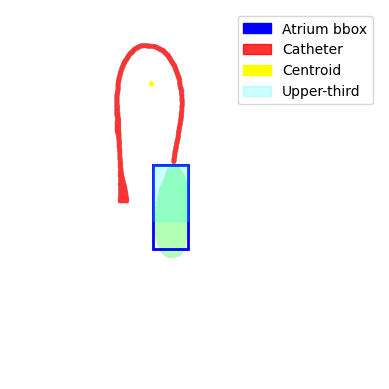

In [ ]:
# Convert the tensors to NumPy arrays
atrium_mask_np = original_atrial_tensor[0].cpu().numpy()
catheter_mask_np = original_cath_tensor[0].cpu().numpy()

# Call viz_spatial_features
viz_spatial_features(atrium_mask_np, catheter_mask_np, features_original_df.iloc[0])

# use original mask and catheter masks to visualize these

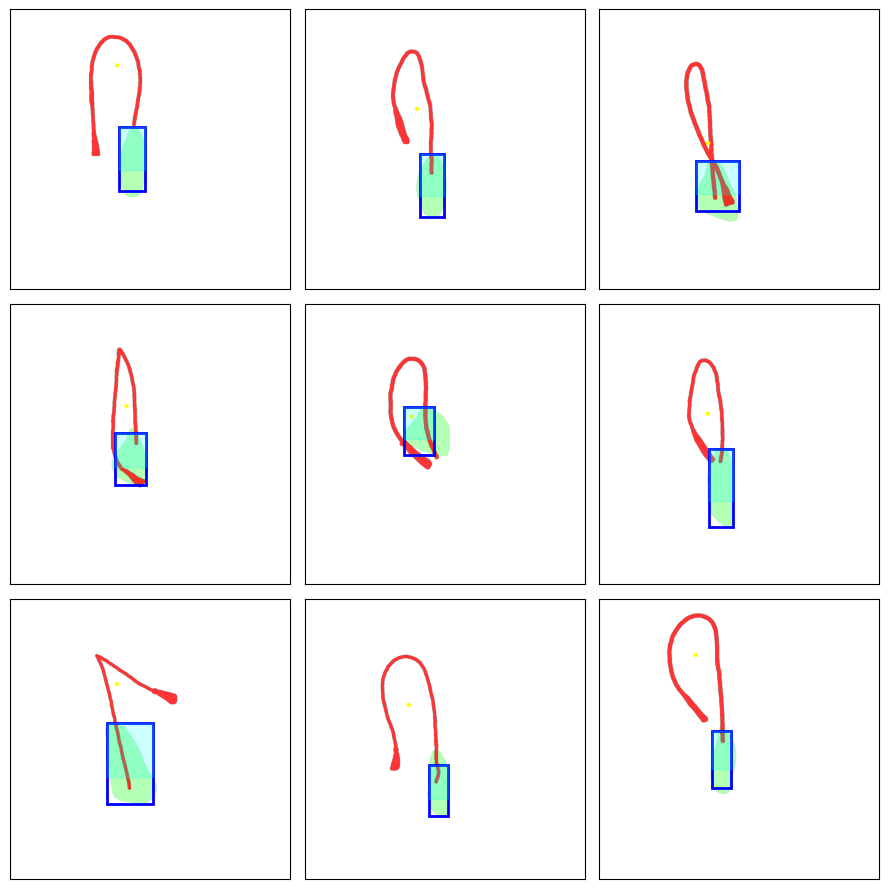

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from skimage.measure import regionprops

# 1) Modify viz_spatial_features to accept an Axes:
def viz_spatial_features(atrium_mask, catheter_mask, features, ax):
    # compute bbox & centroid exactly as before…
    atrium_props = regionprops(atrium_mask.astype(int))[0]
    minr, minc, maxr, maxc = atrium_props.bbox
    H = maxr - minr
    width = maxc - minc

    catheter_props = regionprops(catheter_mask.astype(int))[0]
    r_cent, c_cent = catheter_props.centroid
    third = H // 3

    # draw atrium background (green, α=0.3)
    atrium_rgba = np.zeros((*atrium_mask.shape, 4), float)
    atrium_rgba[atrium_mask>0,1] = 1
    atrium_rgba[atrium_mask>0,3] = 0.3
    ax.imshow(atrium_rgba)

    # draw catheter (red, α=0.8)
    cath_rgba = np.zeros((*catheter_mask.shape,4), float)
    cath_rgba[catheter_mask>0,0] = 1
    cath_rgba[catheter_mask>0,3] = 0.8
    ax.imshow(cath_rgba)

    # bbox, centroid, upper‐third
    ax.add_patch(Rectangle((minc, minr), width, H,
                           fill=False, lw=2, edgecolor='blue'))
    ax.add_patch(Circle((c_cent, r_cent), 5, color='yellow'))
    ax.add_patch(Rectangle((minc, minr), width, 2*third,
                           fill=True, alpha=0.2, color='cyan'))

    ax.set_xticks([]); ax.set_yticks([])

# 2) Prepare your 9 samples:
#    Suppose you have lists: atria = [atrium1, …, atrium9],
#                            caths = [cat1, …, cat9],
#                            feats = [feat1, …, feat9]
#    Replace these with your actual data.
atria = original_atrial_tensor[:9]
caths = original_cath_tensor[:9]
feats = features_original_df.head(9)  # your real features dicts go here

# 3) Create 3×3 grid and plot
fig, axes = plt.subplots(3,3, figsize=(9,9))
for ax, atr_mask, cath_mask, fdict in zip(axes.flat, atria, caths, feats):
    viz_spatial_features(atr_mask.numpy(), cath_mask.numpy(), fdict, ax)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def find_no_segmentation_indices(catheter_masks, atrium_masks):
    """
    Finds the indices where no segmentation is obtained for either the
    catheter or the atrium.

    Args:
        catheter_masks: A NumPy array or tensor containing the catheter masks.
        atrium_masks: A NumPy array or tensor containing the atrium masks.

    Returns:
        A list of indices where no segmentation is obtained.
    """

    no_segmentation_indices = []

    # Assuming catheter_masks and atrium_masks have the same shape
    for i in range(catheter_masks.shape[0]):
        catheter_mask = catheter_masks[i]
        atrium_mask = atrium_masks[i]

        # Check for empty segmentation
        if np.all(catheter_mask == 0) or np.all(atrium_mask == 0):
            no_segmentation_indices.append(i)

    return no_segmentation_indices

# Example usage:
# Assuming catheter_tensor and atrium_tensor are your catheter and atrium mask tensors
no_segmentation_indices = find_no_segmentation_indices(catheter_tensor.cpu().numpy(), atrium_tensor.cpu().numpy())
print("Indices with no segmentation:", no_segmentation_indices)

Indices with no segmentation: []


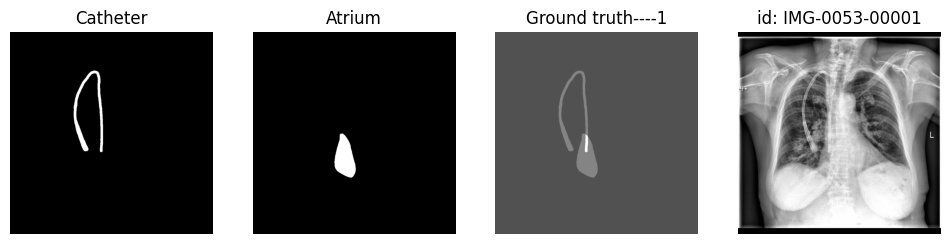

In [ ]:
def viz_intersection(atrium_mask, catheter_mask, original_image, label, id):
    inter = atrium_mask & catheter_mask
    union = atrium_mask | catheter_mask

    fig, axes = plt.subplots(1,4, figsize=(12,5))
    axes[0].imshow(catheter_mask, cmap='gray'); axes[0].set_title("Catheter")
    axes[1].imshow(atrium_mask, cmap='gray');    axes[1].set_title("Atrium")
    axes[2].imshow(inter, alpha=0.6, cmap="gray");
    axes[2].imshow(union, alpha=0.2, cmap="gray");
    axes[2].set_title("Ground truth" + f'----{label}')
    axes[3].imshow(original_image, cmap='gray')
    axes[3].set_title(f'id: {id}')
    for ax in axes: ax.axis('off')
    plt.show()
idx = 15
viz_intersection(train_ground_truth_atrium[idx].cpu().numpy().astype(bool), train_ground_truth_catheter[idx].cpu().numpy().astype(bool),
                 train_clahes[idx], train_tip_labels[idx], common_ids[idx])

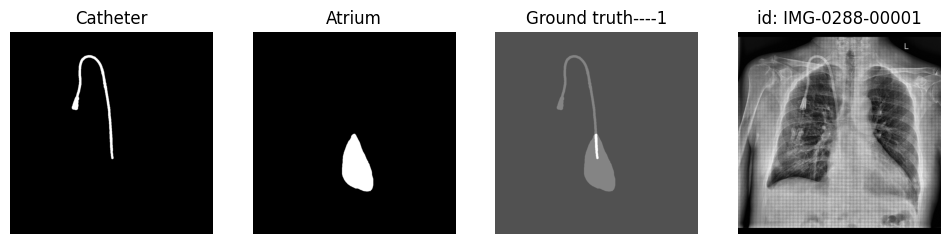

In [ ]:
test_idx = 22
viz_intersection(ground_truth_atrium[test_idx].cpu().numpy().astype(bool), ground_truth_catheter[test_idx].cpu().numpy().astype(bool),
                 test_clahes[test_idx], test_tip_labels[test_idx], common_ids_test[test_idx])

In [ ]:
met_df.loc[met_df['ap_id'] == common_ids[idx]]

ap_id          lat_id  arch  tip
26  IMG-0053-00001  IMG-0054-00001     1    1

Indices to verify with medical team.
These are based on visually inspecting the intersection over union visualization above and identifying ambiguities

In [ ]:
train_indices_to_check = [8, 14, 18, 21, 24, 25, 27, 32, 33, 36, 37, 41, 53, 56, 57, 59, 60, 61,
                          52, 66, 71, 72, 74, 77, 85, 89, 92, 100, 106, 111]
print(len(train_indices_to_check))

test_indices_to_check = [6, 10, 11, 17, 22, 24]

print(len(test_indices_to_check))

30
6


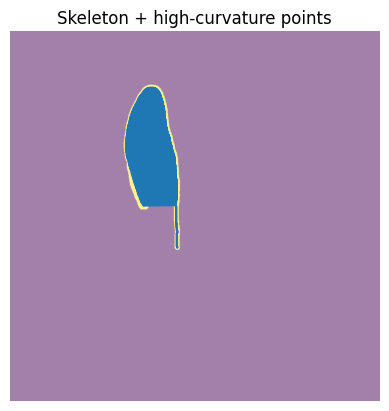

In [ ]:
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from skimage.measure import regionprops

def viz_skeleton_curvature(catheter_mask, some_threshold=0.5):  # Add threshold argument
    # coords = list of skeleton (row, col) points

    # Skeletonize the catheter mask
    skel = skeletonize(catheter_mask)

    # Get coordinates of skeleton points
    ys, xs = np.nonzero(skel)
    coords = list(zip(ys, xs))

    # Calculate angles
    vecs = np.diff(np.vstack([ys, xs]).T, axis=0)
    angles = np.arctan2(vecs[:, 0], vecs[:, 1])

    # ... (rest of the function remains the same)

    fig, ax = plt.subplots()
    ax.imshow(catheter_mask, alpha=0.5)
    ys, xs = zip(*coords)
    ax.plot(xs, ys, linewidth=1)   # skeleton line
    # mark points where turning‐angle is high
    for (r, c), ang in zip(coords[1:], angles):
        if abs(ang) > some_threshold:  # Use the threshold
            ax.add_patch(Circle((c, r), radius=3, alpha=0.7))
    ax.set_title("Skeleton + high‐curvature points")
    plt.axis('off')
    plt.show()

# Example usage with a threshold of 0.5 (adjust as needed)
viz_skeleton_curvature(train_ground_truth_catheter[1].cpu().numpy(), some_threshold=0.5)

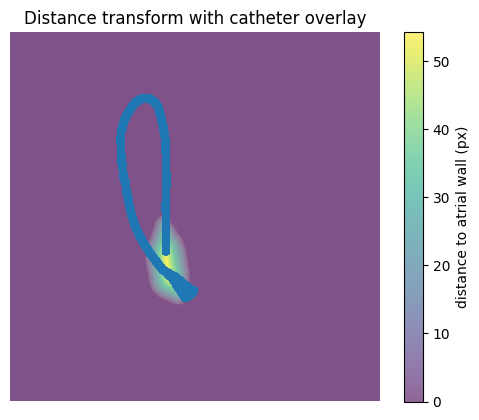

In [ ]:
from scipy.ndimage import distance_transform_edt  # Import the function

def viz_distance_transform(atrium_mask, catheter_mask):
    # Calculate distance transform inside the function
    dt = distance_transform_edt(atrium_mask)

    fig, ax = plt.subplots()
    ax.imshow(atrium_mask, alpha=0.2)
    # display distance transform as a translucent heatmap
    hm = ax.imshow(dt, cmap='viridis', alpha=0.6)
    fig.colorbar(hm, ax=ax, label='distance to atrial wall (px)')
    # highlight catheter pixels
    ax.scatter(*np.nonzero(catheter_mask)[::-1], s=1)
    ax.set_title("Distance transform with catheter overlay")
    plt.axis('off')
    plt.show()

# Now call the function with only the atrium and catheter masks
viz_distance_transform(train_ground_truth_atrium[13].cpu().numpy(), train_ground_truth_catheter[13].cpu().numpy())

In [ ]:
from scipy.ndimage import distance_transform_edt
import numpy as np

def calculate_catheter_atrium_distances(atrium_mask, catheter_mask):
    """Calculates distance measures between catheter and atrium."""

    # 1. Calculate distance transform
    dt = distance_transform_edt(atrium_mask)

    # 2. Get catheter pixel coordinates
    catheter_coords = np.nonzero(catheter_mask)

    # 3. Sample distances at catheter pixels
    distances = dt[catheter_coords]

    # 4. Calculate summary statistics
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    min_distance = np.min(distances)
    max_distance = np.max(distances)

    # You can add more statistics as needed (e.g., percentiles)

    return {
        "mean_distance": mean_distance,
        "std_distance": std_distance,
        "min_distance": min_distance,
        "max_distance": max_distance,
        # ... other statistics
    }

# Example usage
atrium_mask = train_ground_truth_atrium[2].cpu().numpy()
catheter_mask = train_ground_truth_catheter[2].cpu().numpy()
distance_measures = calculate_catheter_atrium_distances(atrium_mask, catheter_mask)
print(distance_measures)

{'mean_distance': np.float64(9.93126430064192), 'std_distance': np.float64(15.874282713780298), 'min_distance': np.float64(0.0), 'max_distance': np.float64(64.88451279003334)}


In [ ]:
import numpy as np

def vertical_distance_features(atrium_mask, catheter_mask):
    # get all row indices where mask is True
    atrium_rows = np.nonzero(atrium_mask)[0]
    cath_rows   = np.nonzero(catheter_mask)[0]

    # extremes:
    atrium_top    = atrium_rows.min()    # smallest row index in atrium
    atrium_bottom = atrium_rows.max()    # largest row index in atrium
    cath_top      = cath_rows.min()      # tip nearest top
    cath_bottom   = cath_rows.max()      # tip nearest bottom

    # distances (in pixels)
    # distance from catheter top to atrium top
    dist_top    = cath_top    - atrium_top
    # distance from catheter bottom to atrium bottom
    dist_bottom = atrium_bottom - cath_bottom

    return {
      "atrium_top": int(atrium_top),
      "atrium_bottom": int(atrium_bottom),
      "cath_top": int(cath_top),
      "cath_bottom": int(cath_bottom),
      "dist_top": int(dist_top),
      "dist_bottom": int(dist_bottom)
    }



feats = vertical_distance_features(atrium_mask, catheter_mask)
atrium_height = feats["atrium_bottom"] - feats["atrium_top"]
feats["dist_top_norm"]    = feats["dist_top"]    / atrium_height
feats["dist_bottom_norm"] = feats["dist_bottom"] / atrium_height
print(feats)

{'atrium_top': 517, 'atrium_bottom': 727, 'cath_top': 181, 'cath_bottom': 676, 'dist_top': -336, 'dist_bottom': 51, 'dist_top_norm': -1.6, 'dist_bottom_norm': 0.24285714285714285}


In [ ]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def tip_distance_features(atrium_mask, catheter_mask):
    """
    Returns only the distances (in px and normalized) from the
    *smallest* (thinnest) catheter end-point (the tip) to the
    atrial top and bottom.
    """
    # 1. find atrium extremes
    atrium_rows = np.nonzero(atrium_mask)[0]
    atrium_top, atrium_bottom = atrium_rows.min(), atrium_rows.max()
    atrium_height = atrium_bottom - atrium_top

    # 2. find catheter extremes (simple vertical extremes)
    cath_rows = np.nonzero(catheter_mask)[0]
    cath_top, cath_bottom = cath_rows.min(), cath_rows.max()

    # 3. measure local thickness at those two rows (use distance-transform)
    dt_cat = distance_transform_edt(catheter_mask)
    # pick any column in catheter at that row (here: first one)
    def local_thickness(r):
        cols = np.nonzero(catheter_mask[r])[0]
        return dt_cat[r, cols].max()*2 if len(cols)>0 else np.inf

    thick_top = local_thickness(cath_top)
    thick_bot = local_thickness(cath_bottom)

    # 4. choose the thinner end = tip
    if thick_top < thick_bot:
        tip_row = cath_top
    else:
        tip_row = cath_bottom

    # 5. compute distances from that tip to atrial boundaries
    dist_to_top    = tip_row - atrium_top
    dist_to_bottom = atrium_bottom - tip_row

    # 6. normalize
    dist_to_top_norm    = dist_to_top    / atrium_height
    dist_to_bottom_norm = dist_to_bottom / atrium_height

    return {
      "tip_row": int(tip_row),
      "dist_to_atrium_top":    int(dist_to_top),
      "dist_to_atrium_bottom": int(dist_to_bottom),
      "dist_to_top_norm":      dist_to_top_norm,
      "dist_to_bot_norm":      dist_to_bottom_norm
    }


In [ ]:
def get_tip_cordinates(catheter):
  # Threshold to binary (catheter is white on black)
  thresh = threshold_otsu(img)
  binary = img > thresh

  # Compute distance transform (distance to nearest background)
  dist = distance_transform_edt(binary)

  # Skeletonize the binary image
  skeleton = skeletonize(binary)

  # Define a kernel to count 8-neighbors
  kernel = np.array([[1,1,1],
                    [1,0,1],
                    [1,1,1]])

  # Find skeleton endpoints: skeleton pixels with only one neighbor
  neighbor_count = convolve(skeleton.astype(int), kernel, mode='constant', cval=0)
  endpoints = np.argwhere((skeleton == 1) & (neighbor_count == 1))

  # For each endpoint, get the local radius (distance transform value)
  radii = [dist[tuple(pt)] for pt in endpoints]

  # Select the endpoint with the minimum width (2 * radius)
  min_idx = np.argmin(radii)
  tip_point = endpoints[min_idx]
  tip_y, tip_x = tip_point  # note: argwhere gives (row, col)

  return tip_x, tip_y

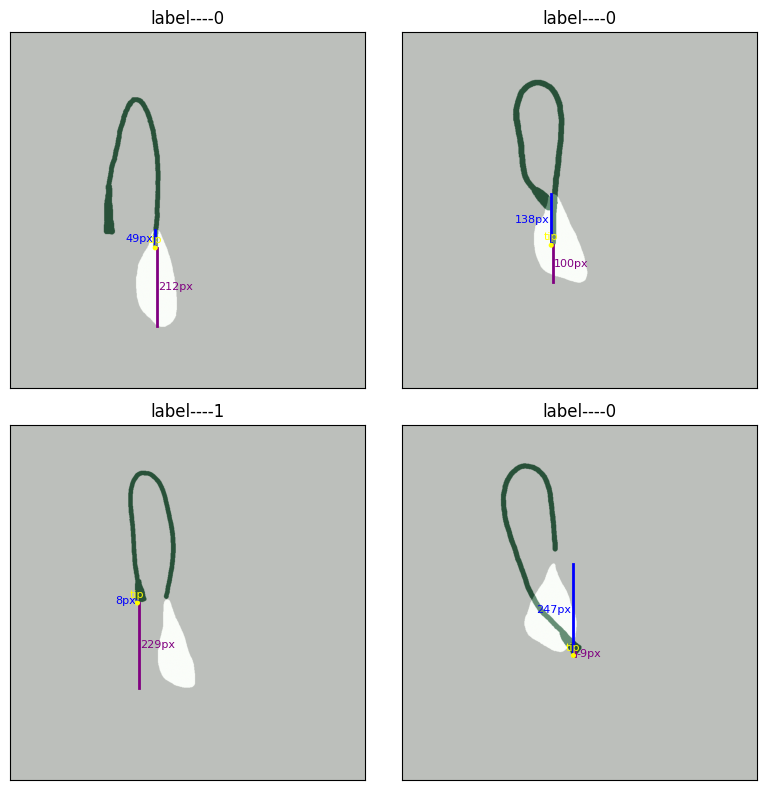

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize
from skimage.measure import regionprops
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

def viz_tip_distance(atrium_mask, catheter_mask, ax=None, label=None):
    """
    Visualize the vertical distance from the true catheter tip (thinner end)
    to the top and bottom of the atrium.

    Args:
        atrium_mask: 2D bool or {0,1} array
        catheter_mask: 2D bool or {0,1} array
        ax: optional matplotlib Axes. If None, a new figure+axes is created.

    Returns:
        ax: the matplotlib Axes with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))

    # 1) find atrial top/bottom
    atrium_rows = np.nonzero(atrium_mask)[0]
    atrium_top, atrium_bottom = atrium_rows.min(), atrium_rows.max()

    # 2) find catheter vertical extremes
    cath_rows = np.nonzero(catheter_mask)[0]
    cath_top, cath_bottom = cath_rows.min(), cath_rows.max()

    # 3) determine which end is the thin tip via distance-transform
    dt_cat = distance_transform_edt(catheter_mask)
    def local_thickness(r):
        cols = np.nonzero(catheter_mask[r])[0]
        return (dt_cat[r, cols].max() * 2) if len(cols)>0 else np.inf

    thick_top = local_thickness(cath_top)
    thick_bot = local_thickness(cath_bottom)
    tip_row = cath_top if thick_top < thick_bot else cath_bottom

    # 4) compute distances
    dist_to_top    = tip_row - atrium_top
    dist_to_bottom = atrium_bottom - tip_row

    # 5) choose an x for drawing (mean catheter column)
    tip_cols = np.nonzero(catheter_mask[tip_row])[0]
    tip_col = int(tip_cols.mean()) if len(tip_cols)>0 else catheter_mask.shape[1]//2

    # 6) plot masks
    ax.imshow(atrium_mask, cmap='gray', alpha=0.6)
    ax.imshow(catheter_mask, cmap='Greens', alpha=0.6)

    # 7) mark the tip
    ax.add_patch(Circle((tip_col, tip_row), radius=5, color='yellow', zorder=5))
    ax.text(tip_col, tip_row-8, "tip", color='yellow', ha='center', va='bottom', fontsize=8)

    # 8) draw vertical lines & annotate
    # line to atrial top
    ax.add_line(Line2D([tip_col, tip_col], [atrium_top, tip_row], linewidth=2, color='blue'))
    ax.text(tip_col-5, (atrium_top+tip_row)/2,
            f"{dist_to_top}px", color='blue', va='center', ha='right', fontsize=8)

    # line to atrial bottom
    ax.add_line(Line2D([tip_col+5, tip_col+5], [tip_row, atrium_bottom], linewidth=2, color='purple'))
    ax.text(tip_col+8, (tip_row+atrium_bottom)/2,
            f"{dist_to_bottom}px", color='purple', va='center', ha='left', fontsize=8)

    # 9) clean up
    # ax.set_title("Tip distance to atrial boundaries")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'label----{label}')
    return ax

# # Example usage:
# fig, ax = plt.subplots()
# viz_tip_distance(original_atrial_tensor[21].cpu().numpy(), original_cath_tensor[21].cpu().numpy(), ax=ax)
# plt.show()

# # plot 4 random viz_tip_distance in a 2x2 grid


import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def plot_2x2_tip_distance(atrium_masks, catheter_masks, indices=None, labels=None):
    """
    Plot 4 random tip-to-atrium visualizations in a 2x2 grid.

    Args:
        atrium_masks: Tensor or array of atrial masks (N, H, W)
        catheter_masks: Tensor or array of catheter masks (N, H, W)
        indices: Optional list of 4 indices to use. If None, randomly sampled.
    """
    assert len(atrium_masks) == len(catheter_masks), "Mismatched input sizes"
    n = len(atrium_masks)

    if indices is None:
        indices = random.sample(range(n), 4)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        atrium_mask = atrium_masks[idx].cpu().numpy()
        catheter_mask = catheter_masks[idx].cpu().numpy()

        # Ensure 2D if originally (1, H, W)
        if atrium_mask.ndim == 3:
            atrium_mask = atrium_mask[0]
        if catheter_mask.ndim == 3:
            catheter_mask = catheter_mask[0]

        viz_tip_distance(atrium_mask, catheter_mask, ax=axes[i], label=labels[i])
        # axes[i].set_title(f"Index {idx}")

    plt.tight_layout()
    plt.show()

# Example usage
plot_2x2_tip_distance(train_ground_truth_atrium, train_ground_truth_catheter, labels=all_labels)


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from scipy.ndimage import convolve, distance_transform_edt

def find_skeleton_endpoints(mask):
    skel = skeletonize(mask)
    # count 8-neighbors for each skeleton pixel
    kernel = np.ones((3,3), int)
    neigh = convolve(skel.astype(int), kernel, mode='constant')
    # endpoints have value 2 (themselves + one neighbor)
    endpoints = np.logical_and(skel, neigh == 2)
    ys, xs = np.nonzero(endpoints)
    return list(zip(ys, xs)), skel

# example:
endpoints, skel = find_skeleton_endpoints(catheter_mask)
# endpoints is [(y1,x1),(y2,x2)]


In [ ]:
dt_cat = distance_transform_edt(catheter_mask)
thicknesses = [dt_cat[y,x]*2 for (y,x) in endpoints]
# the smaller thickness → the tip
tip_idx = np.argmin(thicknesses)
tip_coord = endpoints[tip_idx]
tip_thickness = thicknesses[tip_idx]


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Converts tensor to PIL
    transforms.Resize((224, 224)),  # Resize
    transforms.ToTensor(),  # Back to tensor (1, H, W)
    transforms.Lambda(lambda x: torch.cat([x, x[0:1]], dim=0))

])



In [ ]:
atrium_tensor[0].shape

torch.Size([960, 960])

In [ ]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

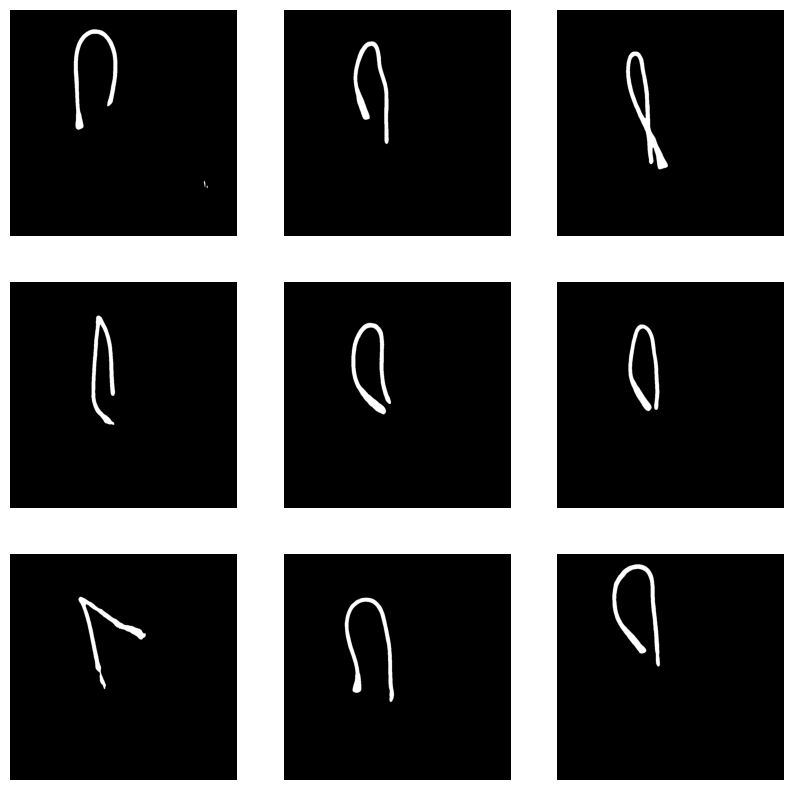

In [ ]:
# plot 9 random test predictions
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(catheter_tensor[i].squeeze(), cmap='gray')

In [ ]:

# join met_df to original features df
original_features_df = features_original_df.join(met_df.set_index('ap_id'), on='ap_id')
original_features_df.head()
# original_features_df.shape

loc_norm  frac_upper    d_mean      d_std  d_min      d_max      length  \
0 -0.537360    0.000000  0.000000   0.000000    0.0   0.000000  502.964623   
1 -0.734884    0.078675  1.723272   6.767466    0.0  42.190046  455.155943   
2 -0.394376    0.306931  9.931264  15.874283    0.0  64.884513  608.767960   
3 -0.197740    0.195364  5.084828   9.833485    0.0  39.812058  566.502397   
4  0.190952    0.119659  5.829131  14.543743    0.0  68.593003  474.708287   

   orientation  eccentricity  curvature  ...  atrium_top  atrium_bottom  \
0    -0.213288      0.854994   2.822437  ...         404            645   
1     0.154725      0.905940   2.849335  ...         496            716   
2     0.238819      0.988148   2.920308  ...         517            727   
3     0.064762      0.974519   2.770936  ...         425            622   
4     0.144281      0.914675   2.971747  ...         351            520   

   tip_row  dist_to_atria_top  dist_to_atria_bottom  min_thickness  \
0      397                 -7                   248       8.944272   
1      561                 65                   155      12.649111   
2      672                155                    55      10.000000   
3      474                 49                   148      12.000000   
4      525                174                    -5      11.661904   

            ap_id          lat_id  arch  tip  
0  IMG-0023-00001  IMG-0024-00001     1    0  
1  IMG-0025-00001  IMG-0026-00001     1    0  
2  IMG-0027-00001  IMG-0028-00001     1    1  
3  IMG-0029-00001  IMG-0030-00001     0    0  
4  IMG-0031-00001  IMG-0032-00001     1    0  

[5 rows x 37 columns]

In [ ]:
met_df.shape

met_df.value_counts('tip')

tip
0    167
1    135
Name: count, dtype: int64

In [ ]:
met_df['tip'].mean(), met_df['arch'].mean()

(np.float64(0.4470198675496689), np.float64(0.8774834437086093))

In [ ]:
# Create a mapping from ap_id to tip
id_to_label = dict(zip(met_df["ap_id"], met_df["tip"]))

# Generate labels in the same order as image_ids
# labels = [id_to_label[img_id] for img_id in ids]

train_labels = [id_to_label[img_id] for img_id in common_ids]
test_labels = [id_to_label[img_id] for img_id in common_ids_test]

# Merge all labels
labels = train_labels + test_labels

labels = np.array(labels)
labels.shape
labels[:10]

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
original_features_df.columns

Index(['loc_norm', 'frac_upper', 'd_mean', 'd_std', 'd_min', 'd_max', 'length',
       'orientation', 'eccentricity', 'curvature', 'hu_catheter_0',
       'hu_catheter_1', 'hu_catheter_2', 'hu_catheter_3', 'hu_catheter_4',
       'hu_catheter_5', 'hu_catheter_6', 'hu_atrium_0', 'hu_atrium_1',
       'hu_atrium_2', 'hu_atrium_3', 'hu_atrium_4', 'hu_atrium_5',
       'hu_atrium_6', 'frac_catheter_in_atrium', 'frac_atrium_covered', 'iou',
       'atrium_top', 'atrium_bottom', 'tip_row', 'dist_to_atria_top',
       'dist_to_atria_bottom', 'min_thickness', 'ap_id', 'lat_id', 'arch',
       'tip'],
      dtype='object')

Selected features from predicted masks


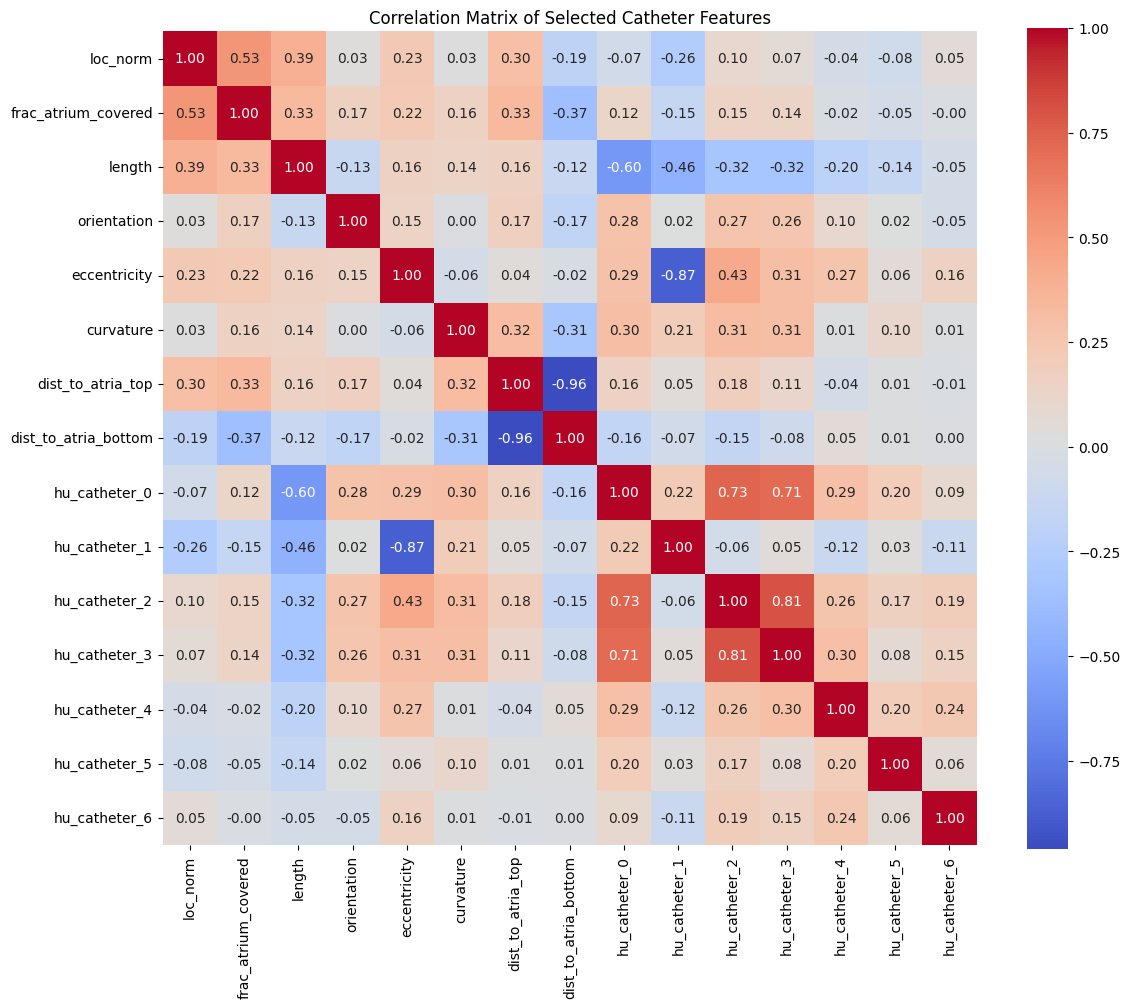



Selected features from original images


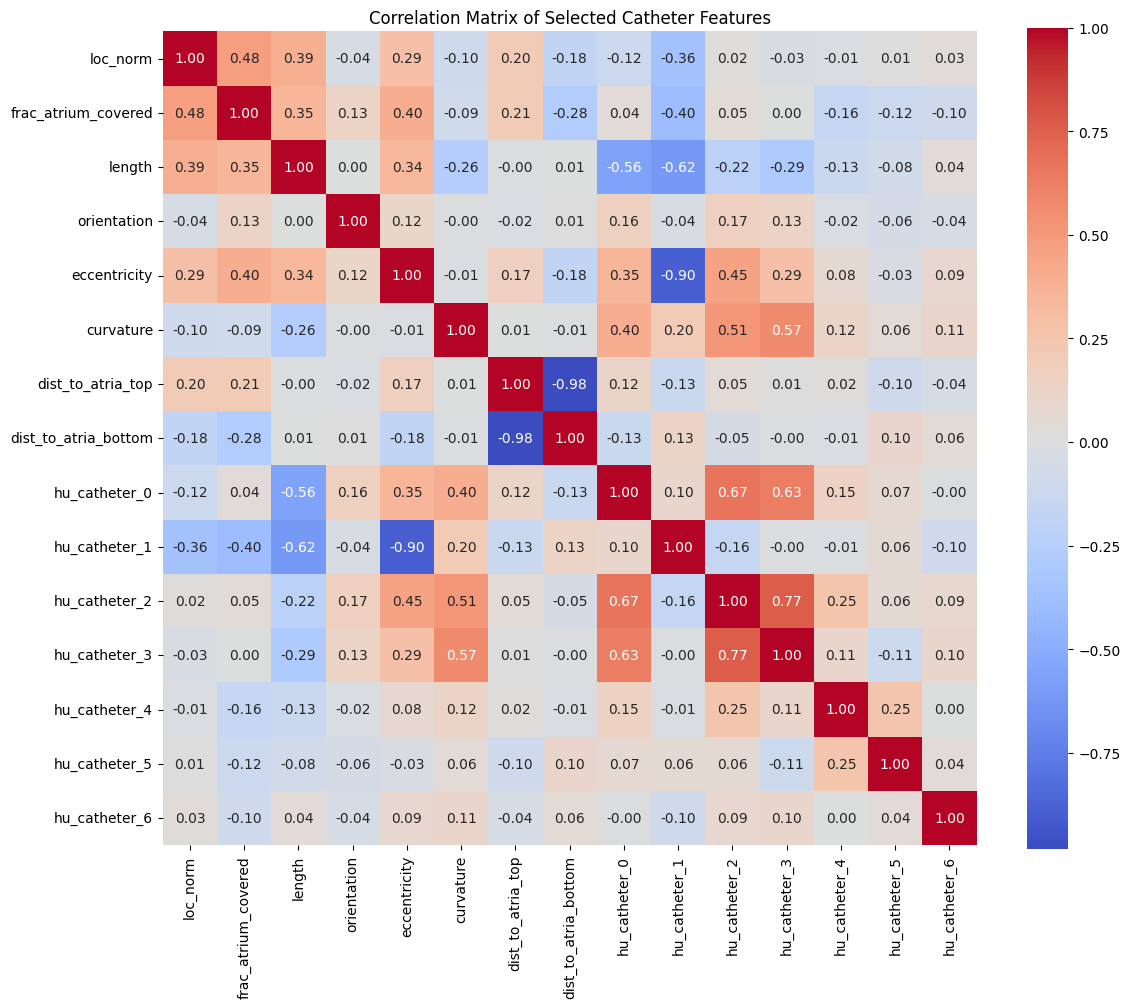

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

def plot_catheter_feature_correlation(df):
    """
    Plots a correlation matrix heatmap of selected catheter segmentation features.

    Args:
        df (pd.DataFrame): DataFrame containing the extracted features.
    """
    selected_columns = [
    "loc_norm", "frac_atrium_covered", "length",
    "orientation", "eccentricity", "curvature", "dist_to_atria_top", "dist_to_atria_bottom"
      ] + [f"hu_catheter_{i}" for i in range(7)]


    # Filter to selected features
    selected_df = df[selected_columns].copy().dropna()

    # Compute correlation matrix
    corr_matrix = selected_df.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title("Correlation Matrix of Selected Catheter Features")
    plt.tight_layout()
    plt.show()


print("Selected features from predicted masks")
plot_catheter_feature_correlation(features_df)

print('\n===============================================\n')

print("Selected features from original images")

plot_catheter_feature_correlation(original_features_df)



In [ ]:
!pip install ace_tools

PCA results for predicted masks


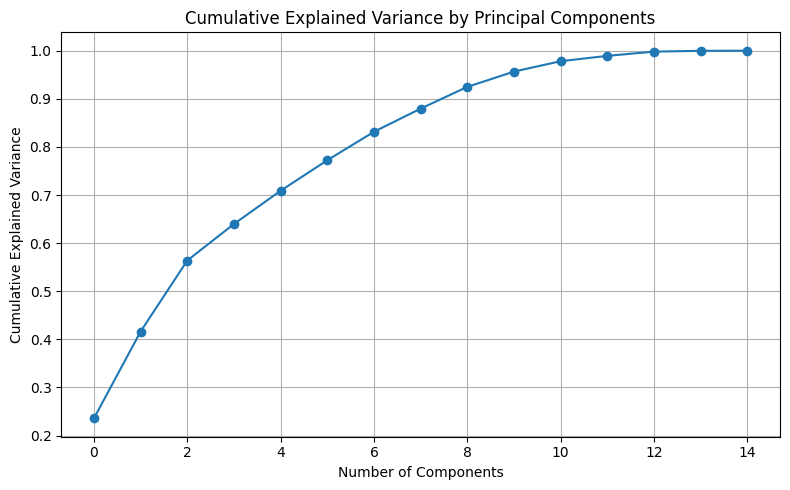

PCA results for original images


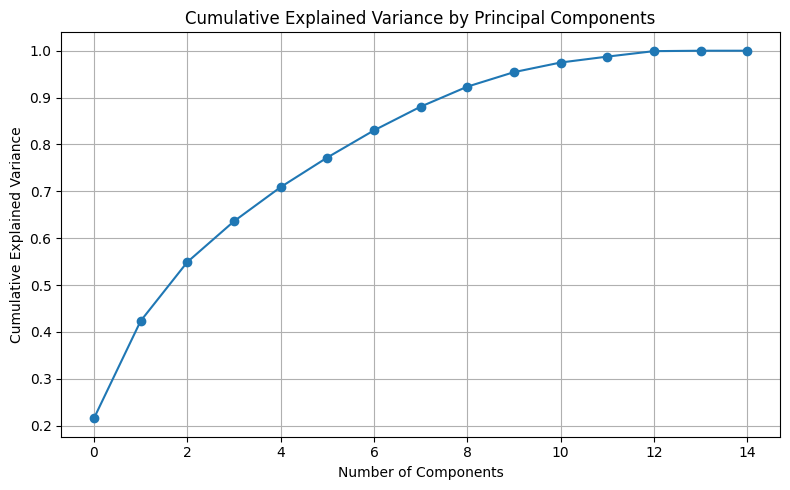

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.141886  0.605689 -0.067579  0.951647  0.773737 -0.600760 -0.556347   
1  0.704669  0.463763 -0.873501 -1.756876  0.845050 -1.385785 -0.123400   
2  1.087532 -3.582850 -0.651370 -2.835196 -0.402902  1.160583 -0.299077   
3 -0.564791 -3.061797  0.112504  0.141249 -1.059389  0.940505 -0.189271   
4  1.650010 -1.747847 -1.450343  0.854931  0.029087  1.573085  1.723009   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.063621  0.285384 -0.235384  0.339116  0.101867 -0.060894 -0.095726   
1 -1.039843  0.042648  0.270454  0.349371 -0.172163  0.340721 -0.083186   
2 -0.186580  1.062591  1.205153 -0.854632 -0.009405 -0.041788  0.082498   
3  0.131370  0.094142  0.758737 -0.117569  0.035586 -0.787768 -0.071320   
4 -0.222768 -1.258161 -0.306137  1.075202 -0.419894  0.421724 -0.350202   

       PC15  
0  0.006644  
1  0.005970  
2 -0.005142  
3  0.003399  
4 -0.017004

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

def perform_catheter_pca(features_df):
    """
    Standardizes selected catheter features, performs PCA,
    and plots cumulative explained variance.

    Args:
        features_df (pd.DataFrame): DataFrame containing the extracted features.

    Returns:
        pd.DataFrame: PCA-transformed feature data (pca_df)
        PCA object: The fitted PCA model
    """
    selected_columns = [
        "loc_norm", "frac_atrium_covered", "length",
        "orientation", "eccentricity", "curvature",
        "dist_to_atria_top", "dist_to_atria_bottom"
    ] + [f"hu_catheter_{i}" for i in range(7)]

    # Filter and standardize the data
    selected_df = features_df[selected_columns].dropna()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_df)

    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca_df, pca


print("PCA results for predicted masks")
pca_df_pred, pca_pred = perform_catheter_pca(features_df)
pca_df_pred.head()


print("PCA results for original images")
pca_df_original, pca_original = perform_catheter_pca(original_features_df)
pca_df_original.head()


In [ ]:
pca_df_original['tip'] = labels
pca_df_pred['tip'] = labels

PCA results for predicted masks


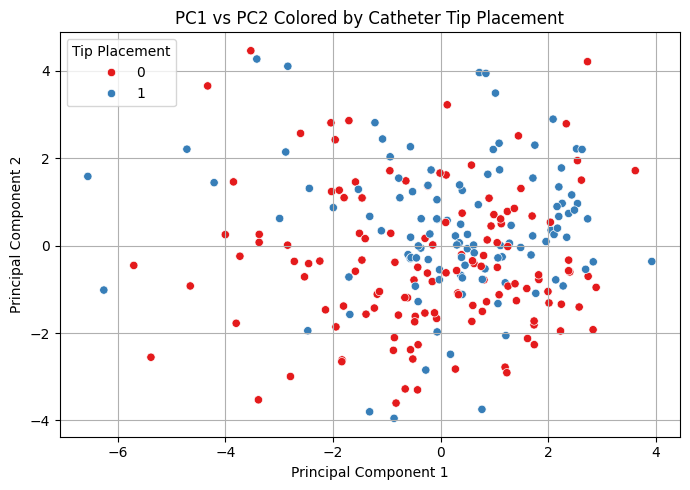



PCA results for original images


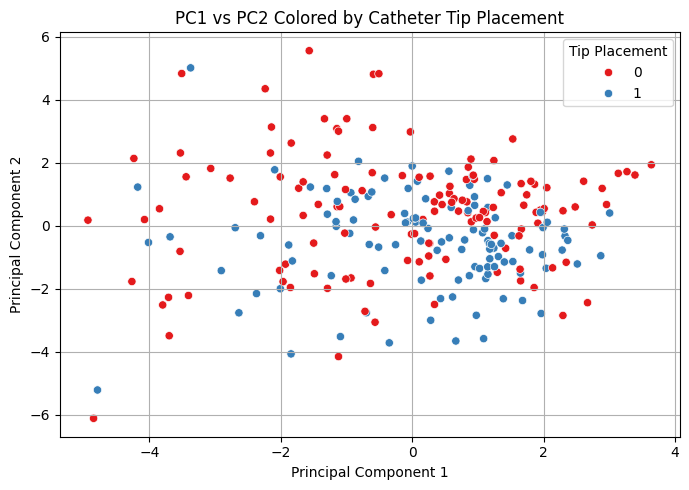

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pca_by_tip(pca_df):
    """
    Plots PC1 vs PC2 from a PCA result, colored by 'tip' label if available.

    Args:
        pca_df (pd.DataFrame): PCA-transformed data (must include PC1 and PC2).
        original_df (pd.DataFrame): Original feature DataFrame (must include 'tip' if coloring is needed).
    """
    if 'tip' in pca_df.columns:
        # Align tip labels to PCA rows (important if any rows were dropped earlier)
        # tip_labels = original_df.loc[pca_df.index, 'tip'].reset_index(drop=True)
        # pca_df = pca_df.copy()
        # pca_df['tip'] = tip_labels

        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='tip', palette='Set1')
        plt.title('PC1 vs PC2 Colored by Catheter Tip Placement')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title='Tip Placement')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_df['PC1'], pca_df['PC2'])
        plt.title('PC1 vs PC2 (No Tip Labels Available)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("PCA results for predicted masks")
plot_pca_by_tip(pca_df_pred)
# predict_catheter_segmentation(unet_model, test_dataloader, device)
print('\n============================================================\n')
print("PCA results for original images")
plot_pca_by_tip(pca_df_original)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define selected features
selected_columns = [
    "loc_norm", "frac_atrium_covered", "dist_to_atria_top", "dist_to_atria_bottom", "length",
    "orientation", "eccentricity", "curvature"
] + [f"hu_catheter_{i}" for i in range(7)]

# Filter and drop NA
filtered_df = original_features_df[selected_columns + ['tip']].dropna() # Keep 'tip' in the filtering process
X = filtered_df[selected_columns]
y = filtered_df['tip']  # Target variable is now aligned with X

# ... (rest of your code)
# Standardize and reduce to 10 PCs in pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

# Display results
mean_score = scores.mean()
std_score = scores.std()

mean_score, std_score




(np.float64(0.6448979591836734), np.float64(0.07022306340442963))

In [ ]:
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

# Define custom scoring
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Placeholder for results
results = {}

# Define selected features
selected_columns = [
    "loc_norm", "frac_atrium_covered", "dist_to_atria_top", "dist_to_atria_bottom", "length",
    "orientation", "eccentricity", "curvature"
] + [f"hu_catheter_{i}" for i in range(7)]

# Filter and drop NA
filtered_df = original_features_df[selected_columns + ['tip']].dropna() # Keep 'tip' in the filtering process
X = filtered_df[selected_columns]
y = filtered_df['tip']  # Target variable is now aligned with X

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
# Prepare results dictionary
cv_results = {}

# Iterate through classifiers
for name, clf in classifiers.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('classifier', clf)
    ])
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
    cv_results[name] = {
        "mean_accuracy": scores['test_accuracy'].mean(),
        "std_accuracy": scores['test_accuracy'].std(),
        "mean_f1": scores['test_f1'].mean(),
        "std_f1": scores['test_f1'].std(),
        "mean_auc": scores['test_roc_auc'].mean(),
        "std_auc": scores['test_roc_auc'].std()
    }

# Convert to DataFrame and display
cv_results_df = pd.DataFrame(cv_results).T
cv_results_df

mean_accuracy  std_accuracy   mean_f1    std_f1  \
Logistic Regression       0.616327      0.059709  0.503961  0.117585   
SVM (RBF Kernel)          0.710204      0.063757  0.690532  0.059897   
Random Forest             0.644898      0.070223  0.592313  0.092972   

                     mean_auc   std_auc  
Logistic Regression  0.707316  0.064183  
SVM (RBF Kernel)     0.770133  0.056256  
Random Forest        0.716859  0.056193

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, matthews_corrcoef
import pandas as pd

def evaluate_classifiers_with_pca(dataframe, target_column='tip', n_components=10):
    """
    Performs PCA and evaluates multiple classifiers using 5-fold cross-validation.

    Args:
        dataframe (pd.DataFrame): The input feature dataframe (must include `target_column`).
        target_column (str): The name of the target column (default is 'tip').
        n_components (int): Number of PCA components to retain (default is 10).

    Returns:
        pd.DataFrame: A summary of mean and std of accuracy, F1 score, and AUC for each model.
    """
    # Define classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42)
    }

    # Scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score),
        'roc_auc': 'roc_auc',
        'matthews_corrcoef': make_scorer(matthews_corrcoef)
    }

    # Define selected features
    selected_columns = [
        "loc_norm", "frac_atrium_covered", "dist_to_atria_top", "dist_to_atria_bottom"

    ]
    # + [f"hu_catheter_{i}" for i in range(7)


    # Drop missing values and align X/y
    filtered_df = dataframe[selected_columns + [target_column]].dropna()
    X = filtered_df[selected_columns]
    y = filtered_df[target_column]

    # 5-fold stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Evaluate each classifier
    results = {}
    for name, clf in classifiers.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            # ('pca', PCA(n_components=n_components)),
            ('classifier', clf)
        ])
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
        results[name] = {
            "mean_accuracy": scores['test_accuracy'].mean(),
            "std_accuracy": scores['test_accuracy'].std(),
            "mean_f1": scores['test_f1'].mean(),
            "std_f1": scores['test_f1'].std(),
            "mean_auc": scores['test_roc_auc'].mean(),
            "std_auc": scores['test_roc_auc'].std(),
            "mean_mcc": scores['test_matthews_corrcoef'].mean(),
            "std_mcc": scores['test_matthews_corrcoef'].std()
        }


    return pd.DataFrame(results).T
predicted_mask_metrics = evaluate_classifiers_with_pca(features_df)
original_mask_metrics = evaluate_classifiers_with_pca(original_features_df)

In [ ]:
predicted_mask_metrics

mean_accuracy  std_accuracy   mean_f1    std_f1  \
Logistic Regression       0.693878      0.040816  0.617204  0.073953   
SVM (RBF Kernel)          0.718367      0.032653  0.693165  0.063431   
Random Forest             0.706122      0.074818  0.664189  0.103721   

                     mean_auc   std_auc  mean_mcc   std_mcc  
Logistic Regression  0.734307  0.041804  0.382582  0.088437  
SVM (RBF Kernel)     0.757492  0.034674  0.438716  0.069176  
Random Forest        0.738641  0.052608  0.407131  0.157422

In [ ]:
original_mask_metrics

mean_accuracy  std_accuracy   mean_f1    std_f1  \
Logistic Regression       0.665306      0.049319  0.582040  0.047560   
SVM (RBF Kernel)          0.767347      0.052588  0.770155  0.046276   
Random Forest             0.791837      0.039573  0.769697  0.052245   

                     mean_auc   std_auc  mean_mcc   std_mcc  
Logistic Regression  0.800676  0.057503  0.327305  0.111482  
SVM (RBF Kernel)     0.823208  0.059612  0.556493  0.103380  
Random Forest        0.867297  0.042939  0.582164  0.079194

In [ ]:
spatial_df = original_features_df[["loc_norm", "frac_atrium_covered", "dist_to_atria_top", "dist_to_atria_bottom", "tip"]]
spatial_df['tip'].mean()
spatial_df['tip'].value_counts()

tip
0    133
1    112
Name: count, dtype: int64

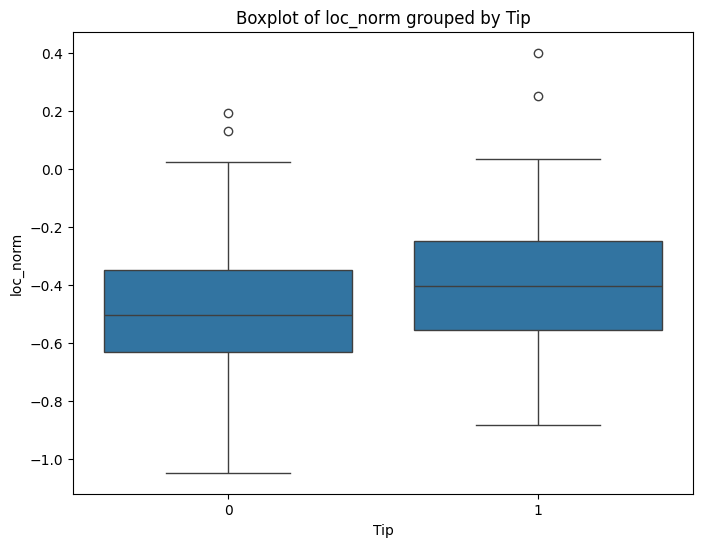

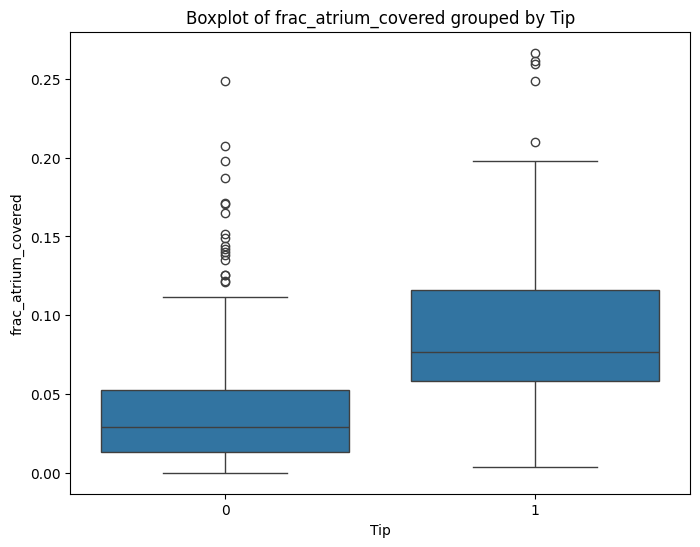

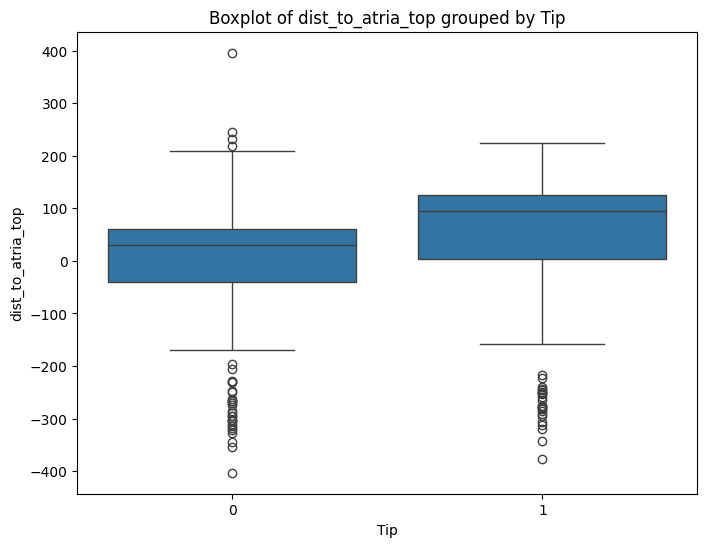

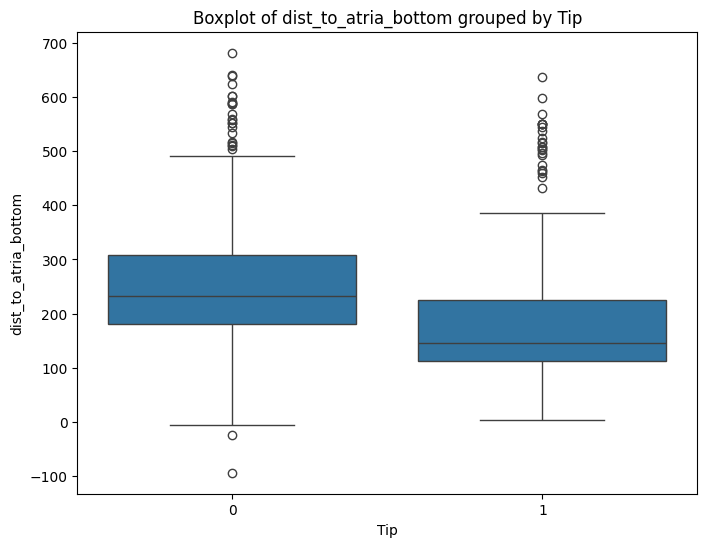

In [ ]:
# prompt: create a boxplot for each variable form spatial df grouped by tip

import matplotlib.pyplot as plt
import seaborn as sns

# Create the boxplots
for column in spatial_df.columns[:-1]:  # Exclude the 'tip' column
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='tip', y=column, data=spatial_df)
    plt.title(f'Boxplot of {column} grouped by Tip')
    plt.xlabel('Tip')
    plt.ylabel(column)
    plt.show()


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ClassificationDataset(Dataset):
    def __init__(self, catheter_predictions,atria_predictions,
                 labels,
                 ids = None,
                 target_size=(224, 224),
                 original_images = None,
                 normalize=False,
                 transform=None):
        # self.predictions = predictions  # Tensor of shape (N, 1, H, W
        self.predictions = catheter_predictions  # Tensor of shape (N, 1, H, W)
        self.labels = torch.tensor(labels, dtype=torch.float32)  # Convert labels to tensor
        self.transform = transform
        self.target_size = target_size  # Desired image size for resizing
        self.atrial_mask = atria_predictions
        self.original_images = original_images
        self.ids = ids
        self.normalize = normalize

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mask = self.predictions[idx]  # Predicted segmentation mask (Tensor)
        label = self.labels[idx]
        atria = self.atrial_mask[idx]



        # Convert mask to NumPy if needed
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)
        if isinstance(atria, np.ndarray):
            atria = torch.from_numpy(atria)

        if self.normalize:
          mask = mask/255.
          atria = atria/255.


        if self.original_images is not None:
          third_channel = self.original_images[idx]/255.
        else:
          third_channel = torch.zeros_like(mask)

        # third_channel = torch.zeros_like(mask)
        feature = torch.stack([mask, atria, third_channel], dim=0)


        # Apply transformation (resize, channel conversion)
        if self.transform:
            feature = self.transform(feature)

        if self.ids is not None:
          return feature, label, self.ids[idx]
        else:
          return feature, label

In [ ]:
from PIL import Image

# Preprocessing pipeline
transform_convnext = transforms.Compose([
    transforms.ToPILImage(),  # Converts tensor to PIL
    transforms.Resize(224),
    transforms.ToTensor()
])

transform_efnet_bo = transforms.Compose([
    transforms.ToPILImage(),  # Converts tensor to PIL
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])


transform_efnet_b7 = transforms.Compose([
    transforms.ToPILImage(),  # Converts tensor to PIL
    transforms.Resize(600, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])



import albumentations as A
from torchvision import transforms

# Albumentations augmentations (geometric only)
med_aug = A.Compose([
    # Safe spatial transforms
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=15, p=0.4, border_mode=0),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        p=0.5,
        border_mode=0
    ),

    # Intensity transforms (conservative)
    A.RandomGamma(gamma_limit=(90, 110)),  # ±10% gamma
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Combined pipeline
transform_efnet_bo_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda x: med_aug(image=np.array(x))['image']),  # Apply albu
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataset
# # full_dataset_ = ClassificationDataset(catheter_tensor, atrium_tensor,  labels, target_size=(224, 224)) # Changed predicted_mask to predicted_masks
# full_dataset_convnext = ClassificationDataset(catheter_tensor, atrium_tensor,  labels, target_size=(224, 224), transform=transform_convnext)
# full_dataset_efnet_bo = ClassificationDataset(catheter_tensor, atrium_tensor,  labels, target_size=(224, 224), transform=transform_efnet_bo)
# full_dataset_efnet_b7 = ClassificationDataset(catheter_tensor, atrium_tensor,  labels, target_size=(224, 224), transform=transform_efnet_b7)
# full_dataset_efnet_bo_aug = ClassificationDataset(catheter_tensor, atrium_tensor,  labels, target_size=(224, 224), transform=transform_efnet_bo_aug)
# full_dataset_original_mask_b7 = ClassificationDataset(catheter_tensotrain_tip_r, atrium_tensor,  labels, target_size=(224, 224), transform=transform_efnet_b7)


In [ ]:
all_original_catheter_masks = torch.cat((train_ground_truth_catheter, ground_truth_catheter), dim=0)
all_original_atrial_masks = torch.cat((train_ground_truth_atrium, ground_truth_atrium), dim=0)
all_original_images = torch.cat((torch.from_numpy(train_clahes), torch.from_numpy(test_clahes)), dim=0)

img_ids = common_ids + common_ids_test
len(img_ids)

245

In [ ]:
print('hello')

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import numpy as np

# Define Albumentations augmentations
albumentations_aug = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,  # ±6.25% of image size
        scale_limit=0.1,     # ±10% scaling
        rotate_limit=15,     # ±15 degrees rotation
        p=0.5
    ),
    A.ElasticTransform(
        alpha=1,
        sigma=50,
        alpha_affine=10,
        p=0.3
    ),
    A.OpticalDistortion(
        distort_limit=0.05,
        shift_limit=0.05,
        p=0.3
    ),
    A.GridDistortion(
        num_steps=5,
        distort_limit=0.3,
        p=0.3
    ),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),  # ImageNet stats
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()  # Converts to (C, H, W) tensor
])

# Wrapper to use Albumentations with PyTorch transforms
class AlbuTransform:
    def __call__(self, img):
        # Convert PIL Image to numpy array
        img_np = np.array(img)
        # Apply Albumentations
        transformed = albumentations_aug(image=img_np)
        return transformed['image']

# # Combined pipeline
# transform_efnet_b7 = transforms.Compose([
#     transforms.ToPILImage(),  # Converts (3, H, W) tensor → PIL Image
#     transforms.Resize((600, 600), interpolation=InterpolationMode.BICUBIC),
#     AlbuTransform(),  # Apply Albumentations augmentations
# ])

hello


<ipython-input-101-154ac88a91a0>:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
<ipython-input-101-154ac88a91a0>:23: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(


In [ ]:
print(all_original_catheter_masks.shape)
print(all_original_atrial_masks.shape)
print(all_original_images.shape)
print(atrium_tensor.shape)
print(catheter_tensor.shape)


transform_efnet_b7 = transforms.Compose([
    transforms.ToPILImage(),  # Converts (3, H, W) tensor → PIL Image
    transforms.Resize((600, 600), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),  # Back to (3, 600, 600)

])

dataset_real_b7 = ClassificationDataset(all_original_catheter_masks,
                                        all_original_atrial_masks,
                                        labels, target_size=(600, 600),
                                        transform=transform_efnet_b7,
                                        ids=img_ids)

dataset_predicted_b7 = ClassificationDataset(catheter_tensor, atrium_tensor,
                                             labels, target_size=(600, 600),
                                             transform=transform_efnet_b7,
                                             ids=img_ids)

dataset_original_atrium_pred_cath_b7 = ClassificationDataset(catheter_tensor, all_original_atrial_masks,
                                             labels, target_size=(600, 600),
                                             transform=transform_efnet_b7,
                                             ids=img_ids)

dataset_original_cath_pred_atria_b7 = ClassificationDataset(all_original_catheter_masks, atrium_tensor,
                                             labels, target_size=(600, 600),
                                             transform=transform_efnet_b7,
                                             ids=img_ids)


dataset_pred_b7_plus_xry = ClassificationDataset(catheter_tensor, atrium_tensor,
                                             labels, target_size=(600, 600),
                                             transform=transform_efnet_b7,
                                              original_images=all_original_images,
                                                 ids=img_ids)

torch.Size([245, 960, 960])
torch.Size([245, 960, 960])
torch.Size([245, 960, 960])
torch.Size([245, 960, 960])
torch.Size([245, 960, 960])


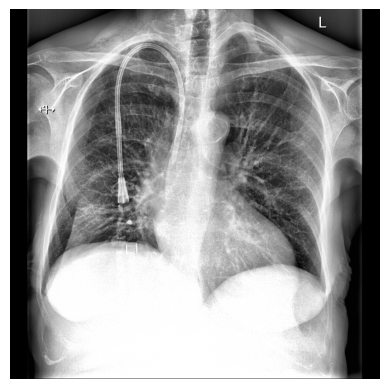

In [ ]:
plt.imshow((all_original_images[0]/255.).cpu().numpy(), cmap="gray")
plt.axis('off');

In [ ]:
# Split dataset (70 train, 14 val)
import torch
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import random_split
train_size = 200
val_size = 45
train_dataset, val_dataset = random_split(dataset_real_b7, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


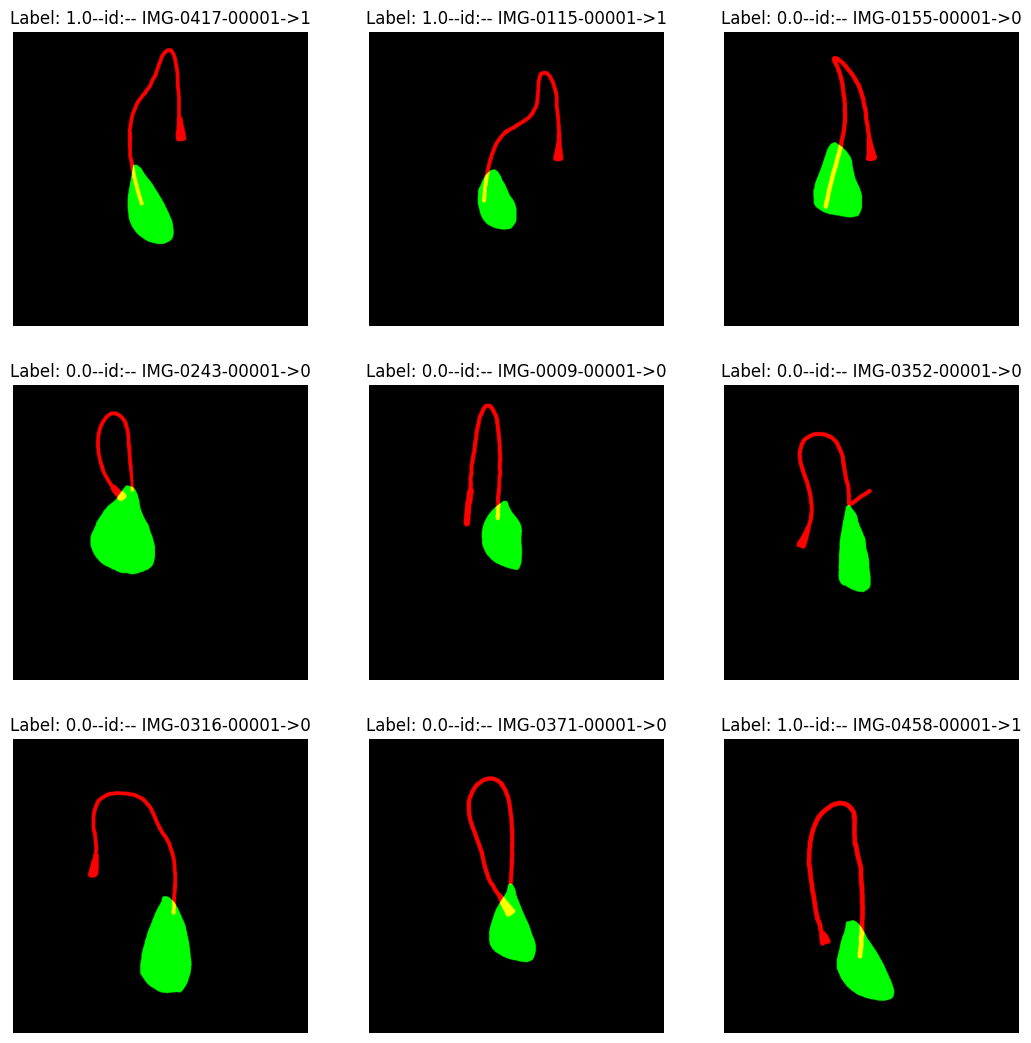

In [ ]:
# plot data from train dataset

import random

# Sanity check
def view_images(dataset, df):
    plt.figure(figsize=(13,13))
    random_indices = random.sample(range(len(dataset)), 9)
    for i, indice in enumerate(random_indices):
        plt.subplot(3,3,i+1)
        plt.axis('off')
        plt.imshow(dataset[indice][0].permute(1, 2, 0).numpy().squeeze())
        plt.title(f"Label: {dataset[indice][1]}--id:-- {dataset[indice][2]}->{int(met_df.loc[met_df['ap_id'] == dataset[indice][2], 'tip'].iloc[0])}")
    plt.show();

view_images(train_dataset, met_df)

In [ ]:
int(met_df.loc[met_df['ap_id'] == 'IMG-0187-00001', 'tip'].iloc[0])

1

In [ ]:
from torchmetrics import F1Score

In [ ]:
from sklearn.model_selection import KFold
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

In [ ]:
# criterion = nn.CrossEntropyLoss()

# dataset = full_dataset_efnet_bo

num_epochs = 50
batch_size = 32
k = 5
splits = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf = {}

In [ ]:
from torchmetrics import Accuracy, Precision, Recall, AUROC, F1Score
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
from torchmetrics import Accuracy
from typing import Tuple

def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
) -> Tuple[float, float]:
    """Train step with TorchMetrics for accuracy calculation."""
    model.train()
    train_loss = 0.0

    # Initialize TorchMetrics Accuracy (binary classification)
    metric = Accuracy(task="binary").to(device)

    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Handle multi-GPU/DP outputs
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Loss computation
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        # Update metrics (FIXED: squeeze predictions to match labels)
        probs = torch.sigmoid(outputs).squeeze(1)  # Shape: [batch_size]
        metric.update(probs, labels)

        # Update loss
        train_loss += loss.item() * images.size(0)

    # Compute final metrics
    avg_loss = train_loss / len(dataloader.dataset)
    avg_acc = metric.compute().item()
    metric.reset()

    scheduler.step()
    return avg_loss, avg_acc



def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[float, float, float, float, float, float]:
    """Test step with proper type handling and metric reset"""
    model.eval()

    # Initialize metrics
    metrics = {
        'acc': Accuracy(task='binary').to(device),
        'precision': Precision(task='binary').to(device),
        'recall': Recall(task='binary').to(device),
        'auc': AUROC(task='binary').to(device),
        'f1': F1Score(task='binary').to(device)
    }

    test_loss = 0.0

    try:
        with torch.no_grad():
            for images, labels, _ in dataloader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # Calculate loss (ensure proper types)
                loss = loss_fn(outputs, labels.float().unsqueeze(1))
                test_loss += loss.item() * images.size(0)

                # Get probabilities and ensure proper shapes
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                # Reshape if needed
                if len(labels.shape) == 1:
                    labels = labels.unsqueeze(1)
                if len(preds.shape) == 1:
                    preds = preds.unsqueeze(1)

                # Update metrics
                for metric in metrics.values():
                    metric.update(preds, labels)

        # Compute final metrics (ensure float conversion)
        avg_loss = float(test_loss / len(dataloader.dataset))
        results = {
            'loss': avg_loss,
            'acc': float(metrics['acc'].compute().item()) ,
            'precision': float(metrics['precision'].compute().item()),
            'recall': float(metrics['recall'].compute().item()),
            'auc': float(metrics['auc'].compute().item()),
            'f1': float(metrics['f1'].compute().item())
        }

        return (
            results['loss'],
            results['acc'],
            results['precision'],
            results['recall'],
            results['auc'],
            results['f1']
        )

    finally:
        # Reset metrics
        for metric in metrics.values():
            metric.reset()



def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Main training loop for multi-GPU setup"""
    results = {
        "train_loss": [], "train_acc": [],
        "test_loss": [], "test_acc": [], "test_f1": []
    }

    for epoch in tqdm(range(epochs)):
        # Training
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, scheduler, device
        )

        # Testing
        test_loss, test_acc, test_f1 = test_step(
            model, test_dataloader, loss_fn, device
        )

        # Print and store results
        print(f"Epoch: {epoch+1:03d} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | "
              f"Test Acc: {test_acc:.4f} | "
              f"Test F1: {test_f1:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_f1"].append(test_f1)

    return results

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.optim import AdamW

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import (
    EfficientNet_B0_Weights,
    EfficientNet_B7_Weights,
    ConvNeXt_Tiny_Weights,
    ConvNeXt_Base_Weights
)

def call_model(model_name='convnext_tiny', device=None, fine_tune=None):
    """
    Initialize ConvNeXt or EfficientNet using torchvision models.

    Args:
        model_name: One of ['convnext_tiny', 'convnext_base', 'efficientnet_b0', 'efficientnet_b7']
        device: torch.device
        fine_tune: None (frozen), 'last_two' (last two blocks), or 'all' (entire model)
    """
    # Device setup
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model initialization with pretrained weights
    if model_name.startswith('convnext'):
        if model_name == 'convnext_tiny':
            weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
            model = models.convnext_tiny(weights=weights)
        elif model_name == 'convnext_base':
            weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
            model = models.convnext_base(weights=weights)
        else:
            raise ValueError(f"Unsupported ConvNeXt variant: {model_name}")

    elif model_name.startswith('efficientnet'):
        if model_name == 'efficientnet_b0':
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1
            model = models.efficientnet_b0(weights=weights)
        elif model_name == 'efficientnet_b7':
            weights = EfficientNet_B7_Weights.IMAGENET1K_V1
            model = models.efficientnet_b7(weights=weights)
        else:
            raise ValueError(f"Unsupported EfficientNet variant: {model_name}")
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Freezing parameters
    if fine_tune is None:
        for param in model.parameters():
            param.requires_grad = False
    elif fine_tune == 'last_two':
        # Unfreeze last two blocks
        if model_name.startswith('convnext'):
            for block in model.features[-2:]:
                for param in block.parameters():
                    param.requires_grad = True
        else:  # EfficientNet
            for layer in model.features[-2:]:
                for param in layer.parameters():
                    param.requires_grad = True
    elif fine_tune == 'all':
        for param in model.parameters():
            param.requires_grad = True
    else:
        raise ValueError("fine_tune must be None, 'last_two', or 'all'")

    # Replace classifier head for binary classification
    if model_name.startswith('convnext'):
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            model.classifier[0],  # Keep LayerNorm2d
            model.classifier[1],  # Keep AdaptiveAvgPool2d
            nn.Flatten(),
            nn.Linear(in_features, 1),

        )
    else:  # EfficientNet
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, 1)

        )



    return model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import (
    EfficientNet_B0_Weights,
    EfficientNet_B7_Weights,
    ConvNeXt_Tiny_Weights,
    ConvNeXt_Base_Weights
)
from sklearn.model_selection import KFold # import KFold to fix NameError
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.optim.lr_scheduler import LinearLR
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import SequentialLR

# Function to free up GPU memory
def free_gpu_memory():
    torch.cuda.empty_cache()
    import gc
    gc.collect()



In [ ]:
def free_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from sklearn.model_selection import KFold
import numpy as np
from tqdm.auto import tqdm
from torchmetrics import F1Score
import gc

def free_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

def train_kfold_model(dataset, model_name='efficientnet_b7', num_epochs=60, batch_size=8, k=5, fine_tune='last_two'):
    """Updated k-fold training with comprehensive metrics"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()

    splits = KFold(n_splits=k, shuffle=True, random_state=42)
    foldperf = {}

    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
        print(f'\n=== Fold {fold + 1}/{k} ===')

        # Data loaders
        effective_batch = batch_size * max(1, num_gpus)
        train_loader = DataLoader(dataset, batch_size=effective_batch,
                                sampler=SubsetRandomSampler(train_idx),
                                pin_memory=True, num_workers=4)
        test_loader = DataLoader(dataset, batch_size=effective_batch,
                               sampler=SubsetRandomSampler(val_idx),
                               pin_memory=True, num_workers=4)

        # Model setup
        model = call_model(model_name=model_name, device='cpu', fine_tune=fine_tune)
        if num_gpus > 1:
            model = nn.DataParallel(model)
        model = model.to(device)

        # Optimizer and loss
        criterion = nn.BCEWithLogitsLoss()
        optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)

        # LR scheduling
        warmup_epochs = 5  # Number of epochs for warmup
        warmup_scheduler = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs)

          # Step 2: Cosine decay scheduler (after warmup)
        cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-6)

          # # Combined scheduler
        from torch.optim.lr_scheduler import SequentialLR
        scheduler = SequentialLR(
              optimizer,
              schedulers=[warmup_scheduler, cosine_scheduler],
              milestones=[warmup_epochs]
              )
        # Enhanced metrics storage
        history = {
            'train_loss': [], 'test_loss': [],
            'train_acc': [], 'test_acc': [],
            'test_precision': [], 'test_recall': [],
            'test_auc': [], 'test_f1': []
        }

        for epoch in tqdm(range(num_epochs), desc=f'Epochs'):
            free_gpu_memory()

            # Training
            train_loss, train_acc = train_step(
                model, train_loader, criterion, optimizer, scheduler, device)

            # Validation with all metrics
            (test_loss, test_acc, test_precision,
             test_recall, test_auc, test_f1) = test_step(
                model, test_loader, criterion, device)

            # Store results
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            history['test_precision'].append(test_precision)
            history['test_recall'].append(test_recall)
            history['test_auc'].append(test_auc)
            history['test_f1'].append(test_f1)

            # Enhanced progress reporting
            if (epoch + 1) % 10 == 0 or epoch == 0 or (epoch + 1) == num_epochs:
                print(f"Epoch {epoch+1:03d} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Train Acc: {train_acc:.2f}% | "
                      f"Test Loss: {test_loss:.4f}\n"
                      f"Test Metrics: "
                      f"Acc: {test_acc*100:.2f}% | "
                      f"Precision: {test_precision:.4f} | "
                      f"Recall: {test_recall:.4f} | "
                      f"AUC: {test_auc:.4f} | "
                      f"F1: {test_f1:.4f}")

        foldperf[f'fold{fold+1}'] = history

    return foldperf

def summarize_kfold_metrics(foldperf):
    """Comprehensive metric summary"""
    metrics = {
        'acc': [], 'precision': [], 'recall': [],
        'auc': [], 'f1': []
    }

    print("\n=== Comprehensive Fold Performance ===")
    for fold in sorted(foldperf.keys()):
        fold_metrics = {
            'acc': foldperf[fold]['test_acc'][-1],
            'precision': foldperf[fold]['test_precision'][-1],
            'recall': foldperf[fold]['test_recall'][-1],
            'auc': foldperf[fold]['test_auc'][-1],
            'f1': foldperf[fold]['test_f1'][-1]
        }

        print(f"\n{fold}:")
        print(f"Accuracy: {fold_metrics['acc']*100:.2f}%")
        print(f"Precision: {fold_metrics['precision']:.4f}")
        print(f"Recall: {fold_metrics['recall']:.4f}")
        print(f"AUC: {fold_metrics['auc']:.4f}")
        print(f"F1: {fold_metrics['f1']:.4f}")

        for k in metrics.keys():
            metrics[k].append(fold_metrics[k])

    print("\n=== Aggregate Metrics ===")
    for metric, values in metrics.items():
        unit = '%' if metric == 'acc' else ''
        print(f"Mean {metric.capitalize()}: {np.mean(values):.4f}{unit} ± {np.std(values):.4f}")

    return metrics

In [ ]:


# Usage example
if __name__ == '__main__':
    # Initialize your dataset
    dataset = dataset_predicted_b7

    # Run k-fold training
    fold_perf = train_kfold_model(
        dataset=dataset,
        model_name='efficientnet_b7',
        num_epochs=70,
        batch_size=8,  # This will be multiplied by number of GPUs
        k=5,
        fine_tune='last_two'
    )

    # Summarize results
    metrics_real = summarize_kfold_metrics(fold_perf)


=== Fold 1/5 ===


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:03<00:00, 85.7MB/s]


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5524 | Train Acc: 0.43% | Test Loss: 0.1391
Test Metrics: Acc: 46.94% | Precision: 0.6000 | Recall: 0.2143 | AUC: 0.5119 | F1: 0.3158
Epoch 010 | Train Loss: 0.0739 | Train Acc: 0.78% | Test Loss: 0.1557
Test Metrics: Acc: 57.14% | Precision: 0.7059 | Recall: 0.4286 | AUC: 0.5952 | F1: 0.5333
Epoch 020 | Train Loss: 0.0274 | Train Acc: 0.79% | Test Loss: 0.3285
Test Metrics: Acc: 73.47% | Precision: 0.7273 | Recall: 0.8571 | AUC: 0.7143 | F1: 0.7869
Epoch 030 | Train Loss: 0.0018 | Train Acc: 0.80% | Test Loss: 0.2456
Test Metrics: Acc: 75.51% | Precision: 0.7667 | Recall: 0.8214 | AUC: 0.7440 | F1: 0.7931
Epoch 040 | Train Loss: 0.0037 | Train Acc: 0.80% | Test Loss: 0.2484
Test Metrics: Acc: 75.51% | Precision: 0.7500 | Recall: 0.8571 | AUC: 0.7381 | F1: 0.8000
Epoch 050 | Train Loss: 0.0037 | Train Acc: 0.80% | Test Loss: 0.2496
Test Metrics: Acc: 77.55% | Precision: 0.7742 | Recall: 0.8571 | AUC: 0.7619 | F1: 0.8136
Epoch 060 | Train Loss: 0.0088 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5494 | Train Acc: 0.47% | Test Loss: 0.1399
Test Metrics: Acc: 44.90% | Precision: 0.3659 | Recall: 0.9375 | AUC: 0.5748 | F1: 0.5263
Epoch 010 | Train Loss: 0.1821 | Train Acc: 0.76% | Test Loss: 0.0761
Test Metrics: Acc: 85.71% | Precision: 0.7143 | Recall: 0.9375 | AUC: 0.8778 | F1: 0.8108
Epoch 020 | Train Loss: 0.0766 | Train Acc: 0.78% | Test Loss: 0.0827
Test Metrics: Acc: 83.67% | Precision: 0.6818 | Recall: 0.9375 | AUC: 0.8627 | F1: 0.7895
Epoch 030 | Train Loss: 0.0192 | Train Acc: 0.80% | Test Loss: 0.0762
Test Metrics: Acc: 85.71% | Precision: 0.7368 | Recall: 0.8750 | AUC: 0.8617 | F1: 0.8000
Epoch 040 | Train Loss: 0.0187 | Train Acc: 0.79% | Test Loss: 0.0431
Test Metrics: Acc: 91.84% | Precision: 0.9286 | Recall: 0.8125 | AUC: 0.8911 | F1: 0.8667
Epoch 050 | Train Loss: 0.0015 | Train Acc: 0.80% | Test Loss: 0.0494
Test Metrics: Acc: 91.84% | Precision: 0.8750 | Recall: 0.8750 | AUC: 0.9072 | F1: 0.8750
Epoch 060 | Train Loss: 0.0019 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5557 | Train Acc: 0.40% | Test Loss: 0.1390
Test Metrics: Acc: 48.98% | Precision: 0.4898 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.6575
Epoch 010 | Train Loss: 0.1457 | Train Acc: 0.76% | Test Loss: 0.1521
Test Metrics: Acc: 69.39% | Precision: 0.7368 | Recall: 0.5833 | AUC: 0.6917 | F1: 0.6512
Epoch 020 | Train Loss: 0.0283 | Train Acc: 0.79% | Test Loss: 0.2093
Test Metrics: Acc: 75.51% | Precision: 0.7308 | Recall: 0.7917 | AUC: 0.7558 | F1: 0.7600
Epoch 030 | Train Loss: 0.0374 | Train Acc: 0.79% | Test Loss: 0.2255
Test Metrics: Acc: 75.51% | Precision: 0.7727 | Recall: 0.7083 | AUC: 0.7542 | F1: 0.7391
Epoch 040 | Train Loss: 0.0037 | Train Acc: 0.80% | Test Loss: 0.2344
Test Metrics: Acc: 75.51% | Precision: 0.7727 | Recall: 0.7083 | AUC: 0.7542 | F1: 0.7391
Epoch 050 | Train Loss: 0.0041 | Train Acc: 0.80% | Test Loss: 0.2667
Test Metrics: Acc: 71.43% | Precision: 0.7778 | Recall: 0.5833 | AUC: 0.7117 | F1: 0.6667
Epoch 060 | Train Loss: 0.0014 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5538 | Train Acc: 0.41% | Test Loss: 0.1386
Test Metrics: Acc: 53.06% | Precision: 0.4091 | Recall: 0.4737 | AUC: 0.5202 | F1: 0.4390
Epoch 010 | Train Loss: 0.0623 | Train Acc: 0.78% | Test Loss: 0.0939
Test Metrics: Acc: 71.43% | Precision: 0.7273 | Recall: 0.4211 | AUC: 0.6605 | F1: 0.5333
Epoch 020 | Train Loss: 0.0330 | Train Acc: 0.79% | Test Loss: 0.2546
Test Metrics: Acc: 75.51% | Precision: 0.6296 | Recall: 0.8947 | AUC: 0.7807 | F1: 0.7391
Epoch 030 | Train Loss: 0.0192 | Train Acc: 0.80% | Test Loss: 0.1168
Test Metrics: Acc: 77.55% | Precision: 0.6538 | Recall: 0.8947 | AUC: 0.7974 | F1: 0.7556
Epoch 040 | Train Loss: 0.0176 | Train Acc: 0.80% | Test Loss: 0.2130
Test Metrics: Acc: 77.55% | Precision: 0.6429 | Recall: 0.9474 | AUC: 0.8070 | F1: 0.7660
Epoch 050 | Train Loss: 0.0023 | Train Acc: 0.80% | Test Loss: 0.1582
Test Metrics: Acc: 77.55% | Precision: 0.6818 | Recall: 0.7895 | AUC: 0.7781 | F1: 0.7317
Epoch 060 | Train Loss: 0.0020 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5526 | Train Acc: 0.41% | Test Loss: 0.1374
Test Metrics: Acc: 53.06% | Precision: 0.5208 | Recall: 1.0000 | AUC: 0.5208 | F1: 0.6849
Epoch 010 | Train Loss: 0.0859 | Train Acc: 0.76% | Test Loss: 0.0923
Test Metrics: Acc: 79.59% | Precision: 0.8571 | Recall: 0.7200 | AUC: 0.7975 | F1: 0.7826
Epoch 020 | Train Loss: 0.0482 | Train Acc: 0.78% | Test Loss: 0.2736
Test Metrics: Acc: 69.39% | Precision: 0.9167 | Recall: 0.4400 | AUC: 0.6992 | F1: 0.5946
Epoch 030 | Train Loss: 0.0093 | Train Acc: 0.80% | Test Loss: 0.3060
Test Metrics: Acc: 75.51% | Precision: 0.8421 | Recall: 0.6400 | AUC: 0.7575 | F1: 0.7273
Epoch 040 | Train Loss: 0.0021 | Train Acc: 0.80% | Test Loss: 0.2469
Test Metrics: Acc: 73.47% | Precision: 0.7727 | Recall: 0.6800 | AUC: 0.7358 | F1: 0.7234
Epoch 050 | Train Loss: 0.0010 | Train Acc: 0.80% | Test Loss: 0.2528
Test Metrics: Acc: 75.51% | Precision: 0.8095 | Recall: 0.6800 | AUC: 0.7567 | F1: 0.7391
Epoch 060 | Train Loss: 0.0025 | Train A

In [ ]:
dataset = dataset_pred_b7_plus_xry

fold_perf_predicted_mask_xry = train_kfold_model(dataset, model_name='efficientnet_b7',
                                             num_epochs=70, batch_size=8, k=5, fine_tune='last_two')
metrics_pred_xry = summarize_kfold_metrics(fold_perf)


=== Fold 1/5 ===


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5530 | Train Acc: 0.42% | Test Loss: 0.1372
Test Metrics: Acc: 57.14% | Precision: 0.5714 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.7273
Epoch 010 | Train Loss: 0.1125 | Train Acc: 0.77% | Test Loss: 0.1283
Test Metrics: Acc: 65.31% | Precision: 0.7037 | Recall: 0.6786 | AUC: 0.6488 | F1: 0.6909
Epoch 020 | Train Loss: 0.0322 | Train Acc: 0.80% | Test Loss: 0.2972
Test Metrics: Acc: 69.39% | Precision: 0.6970 | Recall: 0.8214 | AUC: 0.6726 | F1: 0.7541
Epoch 030 | Train Loss: 0.0138 | Train Acc: 0.80% | Test Loss: 0.3302
Test Metrics: Acc: 71.43% | Precision: 0.7333 | Recall: 0.7857 | AUC: 0.7024 | F1: 0.7586
Epoch 040 | Train Loss: 0.0021 | Train Acc: 0.80% | Test Loss: 0.3311
Test Metrics: Acc: 71.43% | Precision: 0.7333 | Recall: 0.7857 | AUC: 0.7024 | F1: 0.7586
Epoch 050 | Train Loss: 0.0010 | Train Acc: 0.80% | Test Loss: 0.3460
Test Metrics: Acc: 73.47% | Precision: 0.7419 | Recall: 0.8214 | AUC: 0.7202 | F1: 0.7797
Epoch 060 | Train Loss: 0.0006 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5540 | Train Acc: 0.39% | Test Loss: 0.1373
Test Metrics: Acc: 61.22% | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.4545 | F1: 0.0000
Epoch 010 | Train Loss: 0.1059 | Train Acc: 0.76% | Test Loss: 0.0829
Test Metrics: Acc: 85.71% | Precision: 0.7143 | Recall: 0.9375 | AUC: 0.8778 | F1: 0.8108
Epoch 020 | Train Loss: 0.0153 | Train Acc: 0.80% | Test Loss: 0.1233
Test Metrics: Acc: 83.67% | Precision: 0.7000 | Recall: 0.8750 | AUC: 0.8466 | F1: 0.7778
Epoch 030 | Train Loss: 0.0778 | Train Acc: 0.76% | Test Loss: 0.1404
Test Metrics: Acc: 83.67% | Precision: 0.9000 | Recall: 0.5625 | AUC: 0.7661 | F1: 0.6923
Epoch 040 | Train Loss: 0.0135 | Train Acc: 0.80% | Test Loss: 0.0977
Test Metrics: Acc: 89.80% | Precision: 0.7895 | Recall: 0.9375 | AUC: 0.9081 | F1: 0.8571
Epoch 050 | Train Loss: 0.0021 | Train Acc: 0.80% | Test Loss: 0.0902
Test Metrics: Acc: 87.76% | Precision: 0.7778 | Recall: 0.8750 | AUC: 0.8769 | F1: 0.8235
Epoch 060 | Train Loss: 0.0010 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5555 | Train Acc: 0.40% | Test Loss: 0.1379
Test Metrics: Acc: 51.02% | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.5000 | F1: 0.0000
Epoch 010 | Train Loss: 0.0673 | Train Acc: 0.78% | Test Loss: 0.2033
Test Metrics: Acc: 73.47% | Precision: 0.7037 | Recall: 0.7917 | AUC: 0.7358 | F1: 0.7451
Epoch 020 | Train Loss: 0.0129 | Train Acc: 0.80% | Test Loss: 0.2170
Test Metrics: Acc: 73.47% | Precision: 0.7200 | Recall: 0.7500 | AUC: 0.7350 | F1: 0.7347
Epoch 030 | Train Loss: 0.0192 | Train Acc: 0.80% | Test Loss: 0.2734
Test Metrics: Acc: 73.47% | Precision: 0.7037 | Recall: 0.7917 | AUC: 0.7358 | F1: 0.7451
Epoch 040 | Train Loss: 0.0033 | Train Acc: 0.80% | Test Loss: 0.2608
Test Metrics: Acc: 73.47% | Precision: 0.6897 | Recall: 0.8333 | AUC: 0.7367 | F1: 0.7547
Epoch 050 | Train Loss: 0.0029 | Train Acc: 0.80% | Test Loss: 0.3244
Test Metrics: Acc: 77.55% | Precision: 0.7241 | Recall: 0.8750 | AUC: 0.7775 | F1: 0.7925
Epoch 060 | Train Loss: 0.0034 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5532 | Train Acc: 0.40% | Test Loss: 0.1399
Test Metrics: Acc: 44.90% | Precision: 0.4000 | Recall: 0.8421 | AUC: 0.5211 | F1: 0.5424
Epoch 010 | Train Loss: 0.1067 | Train Acc: 0.77% | Test Loss: 0.1485
Test Metrics: Acc: 57.14% | Precision: 0.4750 | Recall: 1.0000 | AUC: 0.6500 | F1: 0.6441
Epoch 020 | Train Loss: 0.0179 | Train Acc: 0.79% | Test Loss: 0.1015
Test Metrics: Acc: 71.43% | Precision: 0.6190 | Recall: 0.6842 | AUC: 0.7088 | F1: 0.6500
Epoch 030 | Train Loss: 0.0024 | Train Acc: 0.80% | Test Loss: 0.1527
Test Metrics: Acc: 71.43% | Precision: 0.6190 | Recall: 0.6842 | AUC: 0.7088 | F1: 0.6500
Epoch 040 | Train Loss: 0.0259 | Train Acc: 0.79% | Test Loss: 0.1335
Test Metrics: Acc: 69.39% | Precision: 0.5833 | Recall: 0.7368 | AUC: 0.7018 | F1: 0.6512
Epoch 050 | Train Loss: 0.0023 | Train Acc: 0.80% | Test Loss: 0.1762
Test Metrics: Acc: 73.47% | Precision: 0.6364 | Recall: 0.7368 | AUC: 0.7351 | F1: 0.6829
Epoch 060 | Train Loss: 0.0015 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5567 | Train Acc: 0.40% | Test Loss: 0.1391
Test Metrics: Acc: 42.86% | Precision: 0.4545 | Recall: 0.6000 | AUC: 0.4250 | F1: 0.5172
Epoch 010 | Train Loss: 0.1325 | Train Acc: 0.76% | Test Loss: 0.1483
Test Metrics: Acc: 69.39% | Precision: 1.0000 | Recall: 0.4000 | AUC: 0.7000 | F1: 0.5714
Epoch 020 | Train Loss: 0.0178 | Train Acc: 0.80% | Test Loss: 0.2548
Test Metrics: Acc: 75.51% | Precision: 0.9333 | Recall: 0.5600 | AUC: 0.7592 | F1: 0.7000
Epoch 030 | Train Loss: 0.0119 | Train Acc: 0.80% | Test Loss: 0.2374
Test Metrics: Acc: 73.47% | Precision: 0.9286 | Recall: 0.5200 | AUC: 0.7392 | F1: 0.6667
Epoch 040 | Train Loss: 0.0038 | Train Acc: 0.80% | Test Loss: 0.2296
Test Metrics: Acc: 77.55% | Precision: 0.9375 | Recall: 0.6000 | AUC: 0.7792 | F1: 0.7317
Epoch 050 | Train Loss: 0.0014 | Train Acc: 0.80% | Test Loss: 0.1951
Test Metrics: Acc: 81.63% | Precision: 0.9444 | Recall: 0.6800 | AUC: 0.8192 | F1: 0.7907
Epoch 060 | Train Loss: 0.0018 | Train A

In [ ]:
dataset = dataset_original_cath_pred_atria_b7

fold_perf_original_cath_pred_atria = train_kfold_model(dataset, model_name='efficientnet_b7',
                                             num_epochs=70, batch_size=8, k=5, fine_tune='last_two')
metrics_original_cath_pred_atria = summarize_kfold_metrics(fold_perf_original_cath_pred_atria)


=== Fold 1/5 ===


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5601 | Train Acc: 0.41% | Test Loss: 0.1383
Test Metrics: Acc: 51.02% | Precision: 0.8333 | Recall: 0.1786 | AUC: 0.5655 | F1: 0.2941
Epoch 010 | Train Loss: 0.0470 | Train Acc: 0.99% | Test Loss: 0.1245
Test Metrics: Acc: 81.63% | Precision: 0.8065 | Recall: 0.8929 | AUC: 0.8036 | F1: 0.8475
Epoch 020 | Train Loss: 0.0029 | Train Acc: 1.00% | Test Loss: 0.2069
Test Metrics: Acc: 81.63% | Precision: 0.7879 | Recall: 0.9286 | AUC: 0.7976 | F1: 0.8525
Epoch 030 | Train Loss: 0.0410 | Train Acc: 0.98% | Test Loss: 0.2514
Test Metrics: Acc: 77.55% | Precision: 0.7179 | Recall: 1.0000 | AUC: 0.7381 | F1: 0.8358
Epoch 040 | Train Loss: 0.0039 | Train Acc: 1.00% | Test Loss: 0.2075
Test Metrics: Acc: 77.55% | Precision: 0.7931 | Recall: 0.8214 | AUC: 0.7679 | F1: 0.8070
Epoch 050 | Train Loss: 0.0018 | Train Acc: 1.00% | Test Loss: 0.2061
Test Metrics: Acc: 79.59% | Precision: 0.7812 | Recall: 0.8929 | AUC: 0.7798 | F1: 0.8333
Epoch 060 | Train Loss: 0.0072 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5567 | Train Acc: 0.48% | Test Loss: 0.1446
Test Metrics: Acc: 32.65% | Precision: 0.3265 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.4923
Epoch 010 | Train Loss: 0.0736 | Train Acc: 0.97% | Test Loss: 0.0582
Test Metrics: Acc: 93.88% | Precision: 1.0000 | Recall: 0.8125 | AUC: 0.9062 | F1: 0.8966
Epoch 020 | Train Loss: 0.0723 | Train Acc: 0.97% | Test Loss: 0.0346
Test Metrics: Acc: 91.84% | Precision: 0.8750 | Recall: 0.8750 | AUC: 0.9072 | F1: 0.8750
Epoch 030 | Train Loss: 0.0040 | Train Acc: 1.00% | Test Loss: 0.0453
Test Metrics: Acc: 91.84% | Precision: 0.8333 | Recall: 0.9375 | AUC: 0.9233 | F1: 0.8824
Epoch 040 | Train Loss: 0.0207 | Train Acc: 0.99% | Test Loss: 0.0766
Test Metrics: Acc: 85.71% | Precision: 0.7368 | Recall: 0.8750 | AUC: 0.8617 | F1: 0.8000
Epoch 050 | Train Loss: 0.0052 | Train Acc: 1.00% | Test Loss: 0.0600
Test Metrics: Acc: 91.84% | Precision: 0.8750 | Recall: 0.8750 | AUC: 0.9072 | F1: 0.8750
Epoch 060 | Train Loss: 0.0016 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5522 | Train Acc: 0.53% | Test Loss: 0.1385
Test Metrics: Acc: 51.02% | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.5000 | F1: 0.0000
Epoch 010 | Train Loss: 0.0891 | Train Acc: 0.95% | Test Loss: 0.0889
Test Metrics: Acc: 75.51% | Precision: 0.7308 | Recall: 0.7917 | AUC: 0.7558 | F1: 0.7600
Epoch 020 | Train Loss: 0.0095 | Train Acc: 1.00% | Test Loss: 0.1954
Test Metrics: Acc: 77.55% | Precision: 0.7241 | Recall: 0.8750 | AUC: 0.7775 | F1: 0.7925
Epoch 030 | Train Loss: 0.0143 | Train Acc: 0.99% | Test Loss: 0.1617
Test Metrics: Acc: 81.63% | Precision: 0.7273 | Recall: 1.0000 | AUC: 0.8200 | F1: 0.8421
Epoch 040 | Train Loss: 0.0018 | Train Acc: 1.00% | Test Loss: 0.1459
Test Metrics: Acc: 81.63% | Precision: 0.7586 | Recall: 0.9167 | AUC: 0.8183 | F1: 0.8302
Epoch 050 | Train Loss: 0.0074 | Train Acc: 0.99% | Test Loss: 0.2322
Test Metrics: Acc: 77.55% | Precision: 0.8824 | Recall: 0.6250 | AUC: 0.7725 | F1: 0.7317
Epoch 060 | Train Loss: 0.0009 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5521 | Train Acc: 0.58% | Test Loss: 0.1340
Test Metrics: Acc: 61.22% | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.5000 | F1: 0.0000
Epoch 010 | Train Loss: 0.0918 | Train Acc: 0.96% | Test Loss: 0.0691
Test Metrics: Acc: 81.63% | Precision: 0.8125 | Recall: 0.6842 | AUC: 0.7921 | F1: 0.7429
Epoch 020 | Train Loss: 0.0465 | Train Acc: 0.98% | Test Loss: 0.0600
Test Metrics: Acc: 85.71% | Precision: 0.7500 | Recall: 0.9474 | AUC: 0.8737 | F1: 0.8372
Epoch 030 | Train Loss: 0.0084 | Train Acc: 1.00% | Test Loss: 0.0853
Test Metrics: Acc: 87.76% | Precision: 0.7826 | Recall: 0.9474 | AUC: 0.8904 | F1: 0.8571
Epoch 040 | Train Loss: 0.0088 | Train Acc: 1.00% | Test Loss: 0.0964
Test Metrics: Acc: 89.80% | Precision: 0.7917 | Recall: 1.0000 | AUC: 0.9167 | F1: 0.8837
Epoch 050 | Train Loss: 0.0019 | Train Acc: 1.00% | Test Loss: 0.0970
Test Metrics: Acc: 89.80% | Precision: 0.7917 | Recall: 1.0000 | AUC: 0.9167 | F1: 0.8837
Epoch 060 | Train Loss: 0.0016 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5597 | Train Acc: 0.44% | Test Loss: 0.1382
Test Metrics: Acc: 51.02% | Precision: 0.5102 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.6757
Epoch 010 | Train Loss: 0.0848 | Train Acc: 0.97% | Test Loss: 0.0986
Test Metrics: Acc: 77.55% | Precision: 1.0000 | Recall: 0.5600 | AUC: 0.7800 | F1: 0.7179
Epoch 020 | Train Loss: 0.1130 | Train Acc: 0.95% | Test Loss: 0.1233
Test Metrics: Acc: 75.51% | Precision: 0.9333 | Recall: 0.5600 | AUC: 0.7592 | F1: 0.7000
Epoch 030 | Train Loss: 0.0272 | Train Acc: 0.99% | Test Loss: 0.0578
Test Metrics: Acc: 89.80% | Precision: 0.9167 | Recall: 0.8800 | AUC: 0.8983 | F1: 0.8980
Epoch 040 | Train Loss: 0.0021 | Train Acc: 1.00% | Test Loss: 0.0572
Test Metrics: Acc: 89.80% | Precision: 0.9545 | Recall: 0.8400 | AUC: 0.8992 | F1: 0.8936
Epoch 050 | Train Loss: 0.0012 | Train Acc: 1.00% | Test Loss: 0.0797
Test Metrics: Acc: 85.71% | Precision: 0.9500 | Recall: 0.7600 | AUC: 0.8592 | F1: 0.8444
Epoch 060 | Train Loss: 0.0026 | Train A

In [ ]:
dataset = dataset_original_atrium_pred_cath_b7

fold_perf_real_mask_normalized = train_kfold_model(dataset, model_name='efficientnet_b7',
                                             num_epochs=70, batch_size=8, k=5, fine_tune='last_two')
metric_original_atrium_pred_cath = summarize_kfold_metrics(fold_perf_real_mask_normalized)


=== Fold 1/5 ===


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5537 | Train Acc: 0.50% | Test Loss: 0.1382
Test Metrics: Acc: 53.06% | Precision: 0.5581 | Recall: 0.8571 | AUC: 0.4762 | F1: 0.6761
Epoch 010 | Train Loss: 0.0612 | Train Acc: 0.97% | Test Loss: 0.2666
Test Metrics: Acc: 69.39% | Precision: 0.7097 | Recall: 0.7857 | AUC: 0.6786 | F1: 0.7458
Epoch 020 | Train Loss: 0.0564 | Train Acc: 0.98% | Test Loss: 0.2097
Test Metrics: Acc: 67.35% | Precision: 0.7143 | Recall: 0.7143 | AUC: 0.6667 | F1: 0.7143
Epoch 030 | Train Loss: 0.0018 | Train Acc: 1.00% | Test Loss: 0.2952
Test Metrics: Acc: 69.39% | Precision: 0.7097 | Recall: 0.7857 | AUC: 0.6786 | F1: 0.7458
Epoch 040 | Train Loss: 0.0817 | Train Acc: 0.98% | Test Loss: 0.1743
Test Metrics: Acc: 71.43% | Precision: 0.7059 | Recall: 0.8571 | AUC: 0.6905 | F1: 0.7742
Epoch 050 | Train Loss: 0.0020 | Train Acc: 1.00% | Test Loss: 0.3416
Test Metrics: Acc: 71.43% | Precision: 0.7188 | Recall: 0.8214 | AUC: 0.6964 | F1: 0.7667
Epoch 060 | Train Loss: 0.0010 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5578 | Train Acc: 0.46% | Test Loss: 0.1397
Test Metrics: Acc: 42.86% | Precision: 0.2000 | Recall: 0.2500 | AUC: 0.3826 | F1: 0.2222
Epoch 010 | Train Loss: 0.0754 | Train Acc: 0.96% | Test Loss: 0.0447
Test Metrics: Acc: 91.84% | Precision: 0.9286 | Recall: 0.8125 | AUC: 0.8911 | F1: 0.8667
Epoch 020 | Train Loss: 0.0236 | Train Acc: 0.99% | Test Loss: 0.0724
Test Metrics: Acc: 85.71% | Precision: 0.7647 | Recall: 0.8125 | AUC: 0.8456 | F1: 0.7879
Epoch 030 | Train Loss: 0.0110 | Train Acc: 0.99% | Test Loss: 0.0693
Test Metrics: Acc: 91.84% | Precision: 0.8750 | Recall: 0.8750 | AUC: 0.9072 | F1: 0.8750
Epoch 040 | Train Loss: 0.0019 | Train Acc: 1.00% | Test Loss: 0.1238
Test Metrics: Acc: 81.63% | Precision: 0.6522 | Recall: 0.9375 | AUC: 0.8475 | F1: 0.7692
Epoch 050 | Train Loss: 0.0020 | Train Acc: 1.00% | Test Loss: 0.0891
Test Metrics: Acc: 89.80% | Precision: 0.8235 | Recall: 0.8750 | AUC: 0.8920 | F1: 0.8485
Epoch 060 | Train Loss: 0.0030 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5565 | Train Acc: 0.49% | Test Loss: 0.1395
Test Metrics: Acc: 48.98% | Precision: 0.4898 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.6575
Epoch 010 | Train Loss: 0.0548 | Train Acc: 0.98% | Test Loss: 0.1335
Test Metrics: Acc: 75.51% | Precision: 0.7308 | Recall: 0.7917 | AUC: 0.7558 | F1: 0.7600
Epoch 020 | Train Loss: 0.0184 | Train Acc: 0.99% | Test Loss: 0.2671
Test Metrics: Acc: 73.47% | Precision: 0.7391 | Recall: 0.7083 | AUC: 0.7342 | F1: 0.7234
Epoch 030 | Train Loss: 0.0204 | Train Acc: 0.99% | Test Loss: 0.2044
Test Metrics: Acc: 73.47% | Precision: 0.7200 | Recall: 0.7500 | AUC: 0.7350 | F1: 0.7347
Epoch 040 | Train Loss: 0.0053 | Train Acc: 1.00% | Test Loss: 0.2314
Test Metrics: Acc: 79.59% | Precision: 0.8182 | Recall: 0.7500 | AUC: 0.7950 | F1: 0.7826
Epoch 050 | Train Loss: 0.0014 | Train Acc: 1.00% | Test Loss: 0.2432
Test Metrics: Acc: 77.55% | Precision: 0.8095 | Recall: 0.7083 | AUC: 0.7742 | F1: 0.7556
Epoch 060 | Train Loss: 0.0013 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5534 | Train Acc: 0.54% | Test Loss: 0.1382
Test Metrics: Acc: 59.18% | Precision: 0.4839 | Recall: 0.7895 | AUC: 0.6281 | F1: 0.6000
Epoch 010 | Train Loss: 0.0948 | Train Acc: 0.97% | Test Loss: 0.1550
Test Metrics: Acc: 63.27% | Precision: 0.5143 | Recall: 0.9474 | AUC: 0.6904 | F1: 0.6667
Epoch 020 | Train Loss: 0.0427 | Train Acc: 0.98% | Test Loss: 0.1392
Test Metrics: Acc: 79.59% | Precision: 0.6800 | Recall: 0.8947 | AUC: 0.8140 | F1: 0.7727
Epoch 030 | Train Loss: 0.0279 | Train Acc: 0.99% | Test Loss: 0.2174
Test Metrics: Acc: 73.47% | Precision: 0.6000 | Recall: 0.9474 | AUC: 0.7737 | F1: 0.7347
Epoch 040 | Train Loss: 0.0036 | Train Acc: 1.00% | Test Loss: 0.1474
Test Metrics: Acc: 77.55% | Precision: 0.6818 | Recall: 0.7895 | AUC: 0.7781 | F1: 0.7317
Epoch 050 | Train Loss: 0.0018 | Train Acc: 1.00% | Test Loss: 0.1546
Test Metrics: Acc: 79.59% | Precision: 0.8000 | Recall: 0.6316 | AUC: 0.7658 | F1: 0.7059
Epoch 060 | Train Loss: 0.0016 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5544 | Train Acc: 0.49% | Test Loss: 0.1384
Test Metrics: Acc: 53.06% | Precision: 0.5217 | Recall: 0.9600 | AUC: 0.5217 | F1: 0.6761
Epoch 010 | Train Loss: 0.0406 | Train Acc: 0.99% | Test Loss: 0.1220
Test Metrics: Acc: 71.43% | Precision: 0.7037 | Recall: 0.7600 | AUC: 0.7133 | F1: 0.7308
Epoch 020 | Train Loss: 0.0425 | Train Acc: 0.97% | Test Loss: 0.2806
Test Metrics: Acc: 79.59% | Precision: 0.8947 | Recall: 0.6800 | AUC: 0.7983 | F1: 0.7727
Epoch 030 | Train Loss: 0.0041 | Train Acc: 1.00% | Test Loss: 0.2056
Test Metrics: Acc: 71.43% | Precision: 0.7391 | Recall: 0.6800 | AUC: 0.7150 | F1: 0.7083
Epoch 040 | Train Loss: 0.0034 | Train Acc: 1.00% | Test Loss: 0.1896
Test Metrics: Acc: 73.47% | Precision: 0.7727 | Recall: 0.6800 | AUC: 0.7358 | F1: 0.7234
Epoch 050 | Train Loss: 0.0016 | Train Acc: 1.00% | Test Loss: 0.2080
Test Metrics: Acc: 71.43% | Precision: 0.7391 | Recall: 0.6800 | AUC: 0.7150 | F1: 0.7083
Epoch 060 | Train Loss: 0.0017 | Train A

In [ ]:
dataset = dataset_real_b7

origininal_b7_perf = train_kfold_model(dataset, model_name='efficientnet_b7',
                                             num_epochs=70, batch_size=8, k=5, fine_tune='last_two')
original_metrics = summarize_kfold_metrics(origininal_b7_perf)


=== Fold 1/5 ===


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5451 | Train Acc: 0.62% | Test Loss: 0.1376
Test Metrics: Acc: 59.18% | Precision: 0.6000 | Recall: 0.8571 | AUC: 0.5476 | F1: 0.7059
Epoch 010 | Train Loss: 0.0763 | Train Acc: 0.95% | Test Loss: 0.1599
Test Metrics: Acc: 79.59% | Precision: 0.7812 | Recall: 0.8929 | AUC: 0.7798 | F1: 0.8333
Epoch 020 | Train Loss: 0.0057 | Train Acc: 1.00% | Test Loss: 0.2193
Test Metrics: Acc: 81.63% | Precision: 0.8065 | Recall: 0.8929 | AUC: 0.8036 | F1: 0.8475
Epoch 030 | Train Loss: 0.0400 | Train Acc: 0.98% | Test Loss: 0.2339
Test Metrics: Acc: 65.31% | Precision: 0.8235 | Recall: 0.5000 | AUC: 0.6786 | F1: 0.6222
Epoch 040 | Train Loss: 0.0038 | Train Acc: 1.00% | Test Loss: 0.1860
Test Metrics: Acc: 81.63% | Precision: 0.7879 | Recall: 0.9286 | AUC: 0.7976 | F1: 0.8525
Epoch 050 | Train Loss: 0.0009 | Train Acc: 1.00% | Test Loss: 0.1949
Test Metrics: Acc: 83.67% | Precision: 0.8125 | Recall: 0.9286 | AUC: 0.8214 | F1: 0.8667
Epoch 060 | Train Loss: 0.0010 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5610 | Train Acc: 0.42% | Test Loss: 0.1412
Test Metrics: Acc: 32.65% | Precision: 0.3265 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.4923
Epoch 010 | Train Loss: 0.1702 | Train Acc: 0.93% | Test Loss: 0.1082
Test Metrics: Acc: 71.43% | Precision: 0.5333 | Recall: 1.0000 | AUC: 0.7879 | F1: 0.6957
Epoch 020 | Train Loss: 0.1151 | Train Acc: 0.95% | Test Loss: 0.0936
Test Metrics: Acc: 79.59% | Precision: 0.6250 | Recall: 0.9375 | AUC: 0.8324 | F1: 0.7500
Epoch 030 | Train Loss: 0.0068 | Train Acc: 0.99% | Test Loss: 0.0375
Test Metrics: Acc: 95.92% | Precision: 1.0000 | Recall: 0.8750 | AUC: 0.9375 | F1: 0.9333
Epoch 040 | Train Loss: 0.0025 | Train Acc: 1.00% | Test Loss: 0.0432
Test Metrics: Acc: 95.92% | Precision: 1.0000 | Recall: 0.8750 | AUC: 0.9375 | F1: 0.9333
Epoch 050 | Train Loss: 0.0012 | Train Acc: 1.00% | Test Loss: 0.0397
Test Metrics: Acc: 95.92% | Precision: 0.9375 | Recall: 0.9375 | AUC: 0.9536 | F1: 0.9375
Epoch 060 | Train Loss: 0.0010 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5556 | Train Acc: 0.50% | Test Loss: 0.1389
Test Metrics: Acc: 48.98% | Precision: 0.4878 | Recall: 0.8333 | AUC: 0.4967 | F1: 0.6154
Epoch 010 | Train Loss: 0.0801 | Train Acc: 0.97% | Test Loss: 0.1359
Test Metrics: Acc: 81.63% | Precision: 0.7273 | Recall: 1.0000 | AUC: 0.8200 | F1: 0.8421
Epoch 020 | Train Loss: 0.0039 | Train Acc: 1.00% | Test Loss: 0.1497
Test Metrics: Acc: 79.59% | Precision: 0.7917 | Recall: 0.7917 | AUC: 0.7958 | F1: 0.7917
Epoch 030 | Train Loss: 0.0033 | Train Acc: 1.00% | Test Loss: 0.2057
Test Metrics: Acc: 81.63% | Precision: 0.8000 | Recall: 0.8333 | AUC: 0.8167 | F1: 0.8163
Epoch 040 | Train Loss: 0.0027 | Train Acc: 1.00% | Test Loss: 0.1864
Test Metrics: Acc: 75.51% | Precision: 0.7500 | Recall: 0.7500 | AUC: 0.7550 | F1: 0.7500
Epoch 050 | Train Loss: 0.0010 | Train Acc: 1.00% | Test Loss: 0.2113
Test Metrics: Acc: 75.51% | Precision: 0.7500 | Recall: 0.7500 | AUC: 0.7550 | F1: 0.7500
Epoch 060 | Train Loss: 0.0016 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5500 | Train Acc: 0.56% | Test Loss: 0.1356
Test Metrics: Acc: 61.22% | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.5000 | F1: 0.0000
Epoch 010 | Train Loss: 0.0961 | Train Acc: 0.96% | Test Loss: 0.0817
Test Metrics: Acc: 81.63% | Precision: 0.7500 | Recall: 0.7895 | AUC: 0.8114 | F1: 0.7692
Epoch 020 | Train Loss: 0.0523 | Train Acc: 0.98% | Test Loss: 0.1042
Test Metrics: Acc: 89.80% | Precision: 0.8182 | Recall: 0.9474 | AUC: 0.9070 | F1: 0.8780
Epoch 030 | Train Loss: 0.0039 | Train Acc: 1.00% | Test Loss: 0.0687
Test Metrics: Acc: 87.76% | Precision: 0.7826 | Recall: 0.9474 | AUC: 0.8904 | F1: 0.8571
Epoch 040 | Train Loss: 0.0169 | Train Acc: 0.99% | Test Loss: 0.0360
Test Metrics: Acc: 93.88% | Precision: 0.8636 | Recall: 1.0000 | AUC: 0.9500 | F1: 0.9268
Epoch 050 | Train Loss: 0.0072 | Train Acc: 0.99% | Test Loss: 0.0538
Test Metrics: Acc: 91.84% | Precision: 0.8947 | Recall: 0.8947 | AUC: 0.9140 | F1: 0.8947
Epoch 060 | Train Loss: 0.0027 | Train A

Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.5542 | Train Acc: 0.53% | Test Loss: 0.1377
Test Metrics: Acc: 51.02% | Precision: 0.5102 | Recall: 1.0000 | AUC: 0.5000 | F1: 0.6757
Epoch 010 | Train Loss: 0.0523 | Train Acc: 0.98% | Test Loss: 0.0361
Test Metrics: Acc: 91.84% | Precision: 1.0000 | Recall: 0.8400 | AUC: 0.9200 | F1: 0.9130
Epoch 020 | Train Loss: 0.0079 | Train Acc: 1.00% | Test Loss: 0.0704
Test Metrics: Acc: 91.84% | Precision: 0.9565 | Recall: 0.8800 | AUC: 0.9192 | F1: 0.9167
Epoch 030 | Train Loss: 0.0042 | Train Acc: 1.00% | Test Loss: 0.1316
Test Metrics: Acc: 89.80% | Precision: 0.8571 | Recall: 0.9600 | AUC: 0.8967 | F1: 0.9057
Epoch 040 | Train Loss: 0.0046 | Train Acc: 1.00% | Test Loss: 0.0598
Test Metrics: Acc: 91.84% | Precision: 0.9200 | Recall: 0.9200 | AUC: 0.9183 | F1: 0.9200
Epoch 050 | Train Loss: 0.0011 | Train Acc: 1.00% | Test Loss: 0.0646
Test Metrics: Acc: 93.88% | Precision: 0.9231 | Recall: 0.9600 | AUC: 0.9383 | F1: 0.9412
Epoch 060 | Train Loss: 0.0008 | Train A

In [ ]:
all_metrics = {'original masks': original_metrics,
                   'predicted masks': metrics_real,
                   'true atrial mask + pred catheter': metric_original_atrium_pred_cath,
                   'true catheter + predicted atrium':metrics_original_cath_pred_atria }

def create_metrics_dataframe(metrics_dict, dataset_name):
    """Create formatted metrics DataFrame for a single dataset"""
    df = pd.DataFrame(metrics_dict)
    stats = pd.DataFrame({
        'Mean': df.mean(),
        'Std': df.std()
    }).round(4)
    # stats['Mean ± Std'] = stats['Mean'].astype(str) + ' ± ' + stats['Std'].astype(str)
    stats['Dataset'] = dataset_name
    stats['metric'] = ['acc', 'precision', 'recall', 'auc', 'f1-score']
    return stats

# Create comparison table for all datasets
comparison_dfs = []
for dataset_name, metrics in all_metrics.items():
    comparison_dfs.append(create_metrics_dataframe(metrics, dataset_name))

final_comparison = pd.concat(comparison_dfs)
# Convert to wide format
wide_df = final_comparison.pivot(index="Dataset", columns="metric", values=["Mean", "Std"])

# Flatten multi-index columns and rename
wide_df.columns = [f"{stat}_{metric}" for stat, metric in wide_df.columns]
wide_df = wide_df.reset_index()

# Reorder columns logically
metric_order = ["acc", "precision", "recall", "auc", "f1-score"]
column_order = ["Dataset"] + [f"{stat}_{met}" for met in metric_order for stat in ["Mean", "Std"]]
wide_df = wide_df[column_order]

wide_df



Dataset  Mean_acc  Std_acc  Mean_precision  \
0                    original masks    0.8816   0.0906          0.8524   
1                   predicted masks   78.3673   6.8603          0.7635   
2  true atrial mask + pred catheter    0.7878   0.0622          0.7733   
3  true catheter + predicted atrium    0.8612   0.0602          0.8505   

   Std_precision  Mean_recall  Std_recall  Mean_auc  Std_auc  Mean_f1-score  \
0         0.0822       0.9152      0.0964    0.8789   0.0950         0.8816   
1         0.0559       0.7800      0.1443    0.7852   0.0740         0.7641   
2         0.0332       0.7723      0.0725    0.7810   0.0661         0.7705   
3         0.0701       0.8632      0.1052    0.8594   0.0666         0.8517   

   Std_f1-score  
0        0.0820  
1        0.0735  
2        0.0302  
3        0.0497

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kfold_curves(foldperf, metric='loss'):
    """
    Plot training and validation curves from k-fold results.

    Args:
        foldperf: Dictionary containing fold results (your format)
        metric: 'loss' or 'acc' (must match your dictionary keys)
    """
    plt.figure(figsize=(12, 6))

    # Determine plot labels
    if metric == 'loss':
        train_key = 'train_loss'
        val_key = 'test_loss'
        train_label = 'Training Loss'
        val_label = 'Validation Loss'
        title = 'Loss Curves'
        ylabel = 'Loss'
    else:
        train_key = 'train_acc'
        val_key = 'test_acc'
        train_label = 'Training Accuracy'
        val_label = 'Validation Accuracy'
        title = 'Accuracy Curves'
        ylabel = 'Accuracy (%)'

    # Plot each fold
    for fold_name, fold_data in foldperf.items():
        epochs = range(1, len(fold_data[train_key]) + 1)

        # Training curve
        plt.plot(epochs, fold_data[train_key],
                alpha=0.3, color='blue', linestyle='--')

        # Validation curve
        plt.plot(epochs, fold_data[val_key],
                alpha=0.3, color='orange', linestyle='--')

    # Calculate and plot mean curves
    all_train = np.array([fold_data[train_key] for fold_data in foldperf.values()])
    all_val = np.array([fold_data[val_key] for fold_data in foldperf.values()])

    mean_train = np.mean(all_train, axis=0)
    mean_val = np.mean(all_val, axis=0)

    plt.plot(epochs, mean_train, 'b-', linewidth=2, label=f'Mean {train_label}')
    plt.plot(epochs, mean_val, 'r-', linewidth=2, label=f'Mean {val_label}')

    plt.title(f'K-Fold {title} (n_folds={len(foldperf)})')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    # Add shaded region for std deviation
    std_val = np.std(all_val, axis=0)
    plt.fill_between(epochs,
                    mean_val - std_val,
                    mean_val + std_val,
                    color='orange', alpha=0.1)

    plt.show()

def plot_all_kfold_metrics(foldperf):
    """Plot all training metrics in a 2x2 grid for your dictionary format"""
    plt.figure(figsize=(15, 12))

    # Define metrics to plot and their positions
    metrics = [
        ('train_loss', 'test_loss', 'Loss'),
        ('train_acc', 'test_acc', 'Accuracy (%)'),
        ('test_precision', None, 'Precision'),
        ('test_f1', None, 'F1 Score')
    ]

    for i, (train_metric, val_metric, title) in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        # For metrics with both train/val
        if val_metric:
            # Plot each fold
            for fold_data in foldperf.values():
                epochs = range(1, len(fold_data[train_metric]) + 1)

                plt.plot(epochs, fold_data[train_metric],
                        alpha=0.2, color='blue', linestyle='--', label='Train' if i==0 else "")
                plt.plot(epochs, fold_data[val_metric],
                        alpha=0.2, color='orange', linestyle='--', label='Val' if i==0 else "")

            # Plot means
            mean_train = np.mean([fold_data[train_metric] for fold_data in foldperf.values()], axis=0)
            mean_val = np.mean([fold_data[val_metric] for fold_data in foldperf.values()], axis=0)

            plt.plot(epochs, mean_train, 'b-', label='Mean Train')
            plt.plot(epochs, mean_val, 'r-', label='Mean Val')
        else:
            # For test-only metrics
            for fold_data in foldperf.values():
                epochs = range(1, len(fold_data[train_metric]) + 1)
                plt.plot(epochs, fold_data[train_metric],
                        alpha=0.2, color='green', linestyle='--')

            mean_metric = np.mean([fold_data[train_metric] for fold_data in foldperf.values()], axis=0)
            plt.plot(epochs, mean_metric, 'g-', label='Mean')

        plt.title(title)
        plt.xlabel('Epochs')
        plt.grid(True)
        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.show()

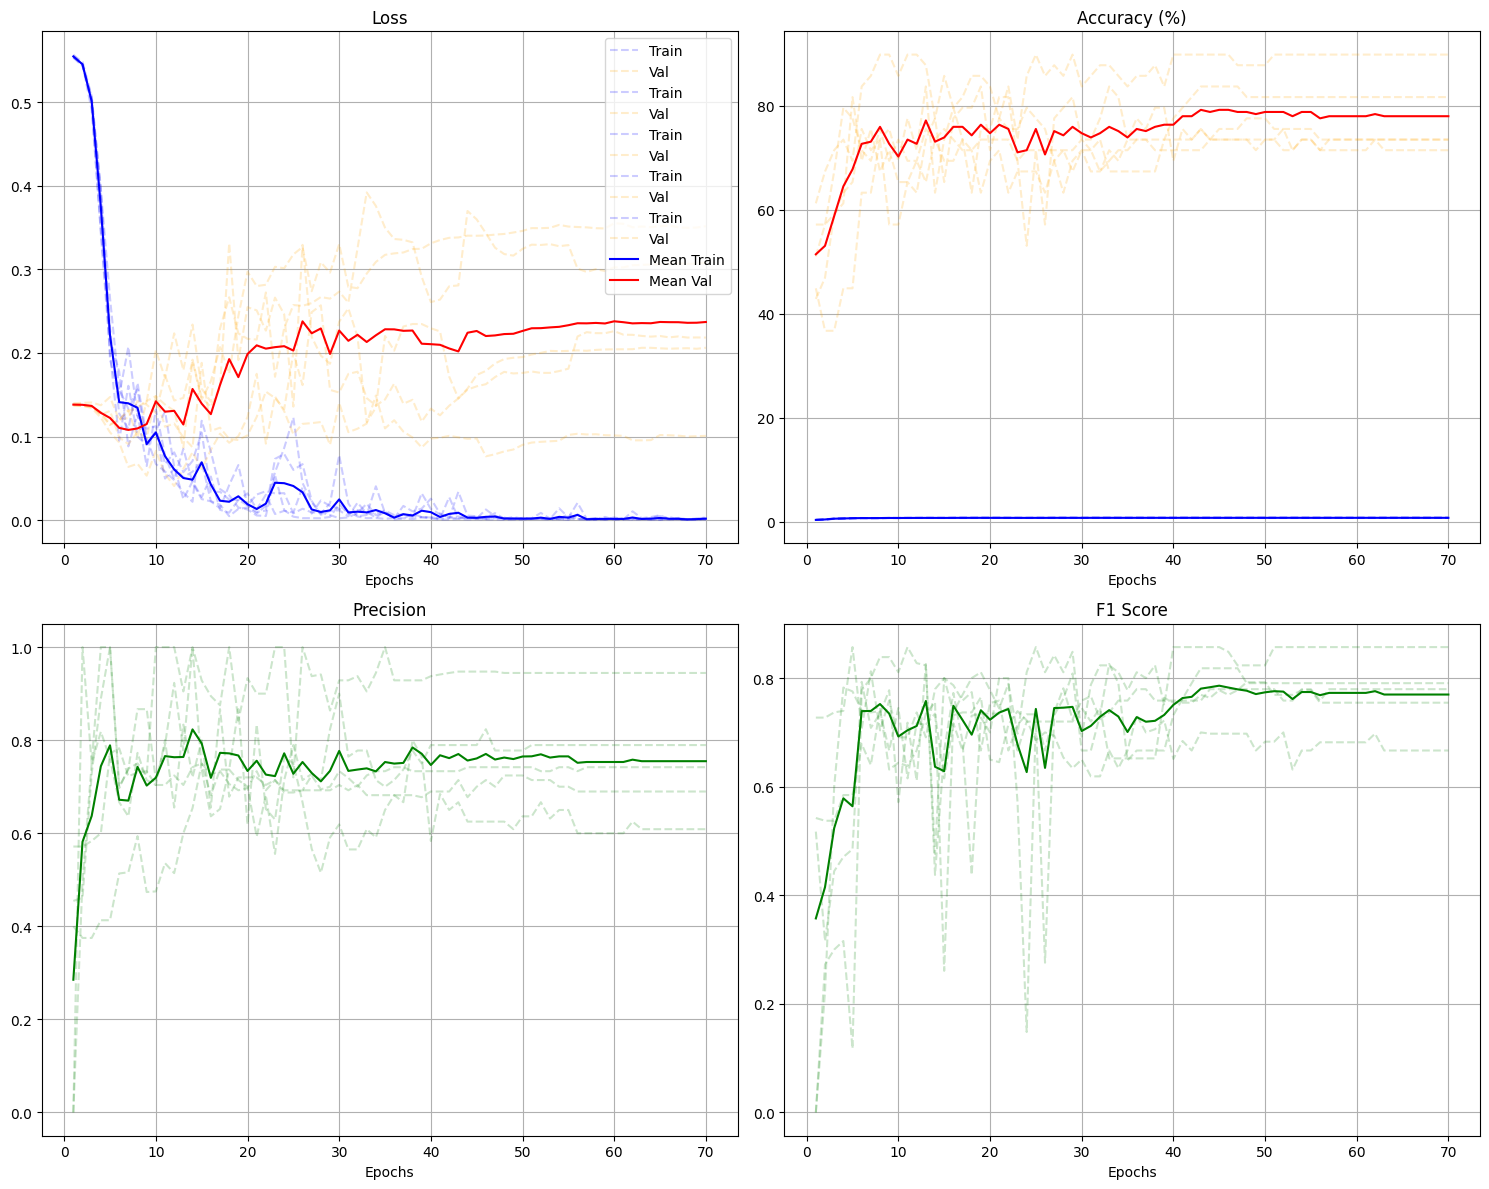

In [ ]:
plot_all_kfold_metrics(fold_perf_predicted_mask_xry)

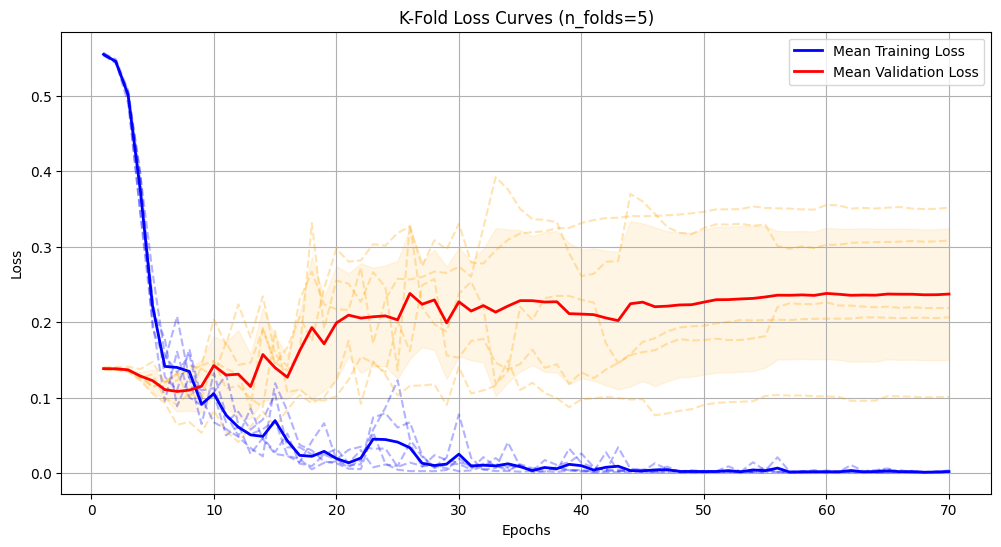

In [ ]:
plot_kfold_curves(fold_perf_predicted_mask_xry, metric='loss')

In [ ]:
# Load EfficientNet B7
from torch.optim import AdamW
torch.manual_seed(42)

# Split dataset (70 train, 14 val)
train_size = 210
val_size = 35
train_dataset, val_dataset = random_split(dataset_real_b7, [train_size, val_size])


In [ ]:
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)



model = call_model(model_name='efficientnet_b7', device=device, fine_tune='last_two')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()



# Define loss function and optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)


# LR scheduling
warmup_epochs = 5  # Number of epochs for warmup
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs)

  # Step 2: Cosine decay scheduler (after warmup)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-6)

  # # Combined scheduler
from torch.optim.lr_scheduler import SequentialLR
scheduler = SequentialLR(
      optimizer,
      schedulers=[warmup_scheduler, cosine_scheduler],
      milestones=[warmup_epochs]
      )

# Training loop
epoch_losses = []
epoch_accuracies = []
for epoch in tqdm(range(num_epochs), desc=f'Epochs'):
  free_gpu_memory()
  train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer, scheduler, device)
  epoch_losses.append(train_loss)
  epoch_accuracies.append(train_acc)
  if (epoch + 1) % 10 == 0 or epoch == 0 or (epoch + 1) == num_epochs:
    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc * 100:.2f}%")



Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.6917 | Train Acc: 52.86%
Epoch 010 | Train Loss: 0.1121 | Train Acc: 97.62%
Epoch 020 | Train Loss: 0.0273 | Train Acc: 99.52%
Epoch 030 | Train Loss: 0.0256 | Train Acc: 99.52%
Epoch 040 | Train Loss: 0.0012 | Train Acc: 100.00%
Epoch 050 | Train Loss: 0.0009 | Train Acc: 100.00%
Epoch 060 | Train Loss: 0.0009 | Train Acc: 100.00%
Epoch 070 | Train Loss: 0.0009 | Train Acc: 100.00%
Epoch 080 | Train Loss: 0.0012 | Train Acc: 100.00%
Epoch 090 | Train Loss: 0.0004 | Train Acc: 100.00%
Epoch 100 | Train Loss: 0.0004 | Train Acc: 100.00%


In [ ]:
from torchmetrics import F1Score

correct = 0
total = 0
f1_score = F1Score(task='binary')

all_predictions = []
all_labels = []
all_ids = []

with torch.inference_mode():
    for images, labels, ids in val_dataloader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        model.eval()
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_ids.extend(ids)


# Calculate F1 score
f1 = f1_score(torch.tensor(all_predictions), torch.tensor(all_labels))



print(f"Validation Accuracy: {100 * correct / total:.2f}%")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 82.86%
Validation F1 Score: 0.8333


<ipython-input-152-39782d9199b6>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  f1 = f1_score(torch.tensor(all_predictions), torch.tensor(all_labels))


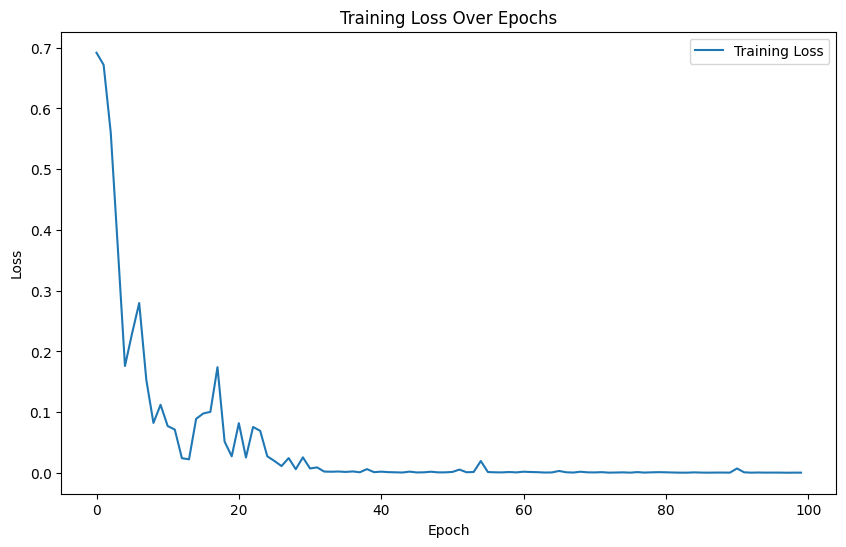

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epoch_losses, label='Training Loss') # Detach the loss tensor
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

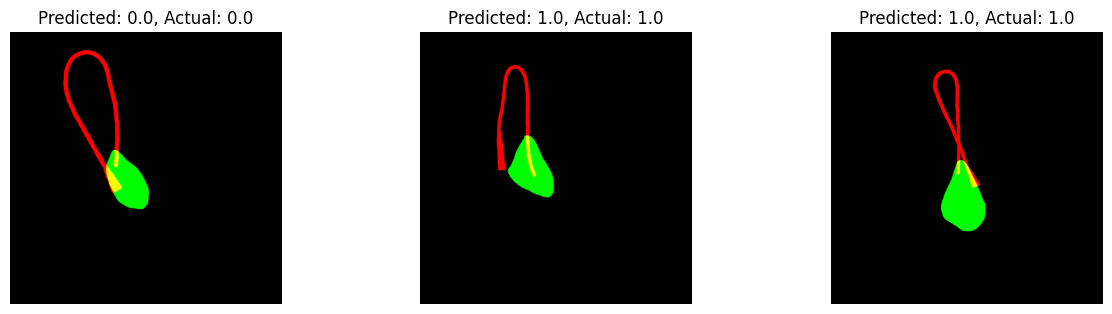

In [ ]:
plt.figure(figsize=(15,12))
for i in range(len(predicted)):  # Change here to iterate over the valid range of 'predicted'
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(val_dataset[i][0].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
    # plt.title(f"Predicted: {predicted[i].item()}")
plt.show();

In [ ]:
# Save model b7
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_uhasselt/models/model-B7-07-May-24-2025.pth')